# Look for patterns in Delta NSE

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/tommy/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
from collections import defaultdict

mpl.rcParams['figure.dpi'] = 150

In [3]:
label_size = 14  # 10
plt.rcParams.update(
    {'axes.labelsize': label_size,
     'legend.fontsize': label_size,
     "font.size": 14,
    }
)


In [4]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [5]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

In [6]:
import sys
sys.path.append("../neuralhydrology")

from neuralhydrology.evaluation.metrics import nse, mse, rmse, kge, fdc_fms, fdc_fhv, fdc_flv, calculate_all_metrics, calculate_metrics

# Read in the CAMELS data

In [7]:
# read in the training data
ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")
ds['station_id'] = ds['station_id'].astype(int)
dynamic = ds

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

# Read AWS Trained Models

In [8]:
# # ealstm_less_vars = pd.read_csv(data_dir / "runs/ealstm_less_vars_2004_1707_1424/results_ealstm_less_vars_2004_1707_1424_E015.csv")
# ealstm_preds = xr.open_dataset(data_dir / "RUNOFF/ealstm_epoch30_ensemble2/results.nc")
# ealstm_preds["station_id"] = [int(sid) for sid in ealstm_preds["station_id"]]
# ealstm_preds = ealstm_preds.rename({"discharge_spec_obs": "obs", "discharge_spec_sim": "sim"})
# ealstm_df = ealstm_preds.to_dataframe().reset_index()

ealstm_df = pd.read_csv(data_dir / "runs/ensemble_EALSTM/data_ENS.csv").drop("Unnamed: 0", axis=1)
ealstm_df["time"] = pd.to_datetime(ealstm_df["time"])
ealstm_preds = ealstm_df.set_index(["station_id", "time"]).to_xarray()

ealstm_preds["station_id"] = [int(sid) for sid in ealstm_preds["station_id"]]

In [9]:
lstm_ensemble_df = pd.read_csv("/cats/datastore/data/runs/ensemble/data_ENS.csv").drop("Unnamed: 0", axis=1)
lstm_ensemble_df["time"] = pd.to_datetime(lstm_ensemble_df["time"])
lstm_ensemble = lstm_ensemble_df.set_index(["station_id", "time"]).to_xarray()
lstm_preds = lstm_ensemble
lstm_df = lstm_preds.to_dataframe().reset_index()

In [10]:
metric_df = pd.read_csv(data_dir / "runs/ensemble/metric_df.csv", index_col=0)
metric_df.columns = [c.lower() for c in metric_df.columns]
metric_df.head()

,station_id,nse,kge,mse,fhv,fms,flv
0,10002,0.898328,0.857653,0.229347,-10.042169,20.175607,4.281218
1,10003,0.926555,0.881110,0.111980,-6.074578,1.342742,28.237229
2,1001,0.876090,0.920412,0.509755,3.647934,-23.746845,70.234474
3,101002,0.757246,0.647206,0.300506,-25.176707,-4.734227,73.409471
4,101005,0.824926,0.796430,0.208704,-18.346511,1.971726,45.197245


# FUSE Data

In [11]:
all_paths = [d for d in (data_dir / "RUNOFF/FUSE/Timeseries_SimQ_Best/").glob("*_Best_Qsim.txt")]

if not (data_dir / "RUNOFF/ALL_fuse_ds.nc").exists():
    all_dfs = []
    for txt in tqdm(all_paths):
        df = pd.read_csv(txt, skiprows=3, header=0)
        df.columns = [c.rstrip().lstrip() for c in df.columns]
        df = df.rename(columns={"YYYY": "year", "MM": "month", "DD": "day"})
        df["time"] = pd.to_datetime(df[["year", "month", "day"]])
        station_id = int(str(txt).split("/")[-1].split("_")[0])
        df["station_id"] = [station_id for _ in range(len(df))]
        df = df.drop(["year", "month", "day", "HH"], axis=1).set_index(["station_id", "time"])
        all_dfs.append(df)
        
    fuse_ds = pd.concat(all_dfs).to_xarray()
    fuse_ds.to_netcdf(data_dir / "RUNOFF/ALL_fuse_ds.nc")
    
else:
    fuse_ds = xr.open_dataset(data_dir / "RUNOFF/ALL_fuse_ds.nc")

In [12]:
fuse_ds = fuse_ds.sel(time=slice('1998-01-01', '2009-01-01'))

In [13]:
# join with observations for stations that exist
obs = (
    ds.sel(station_id=np.isin(ds["station_id"], fuse_ds["station_id"]), time=fuse_ds["time"])["discharge_spec"]
).rename("obs")
fuse_data = fuse_ds.sel(station_id=obs.station_id).merge(obs)

In [14]:
fuse_data

<xarray.Dataset>
Dimensions:          (station_id: 519, time: 4018)
Coordinates:
  * station_id       (station_id) int64 1001 2001 2002 ... 101005 102001 106001
  * time             (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
Data variables:
    SimQ_TOPMODEL    (station_id, time) float64 ...
    SimQ_ARNOVIC     (station_id, time) float64 ...
    SimQ_PRMS        (station_id, time) float64 ...
    SimQ_SACRAMENTO  (station_id, time) float64 ...
    obs              (time, station_id) float64 ...

# Match Stations / Times

In [15]:
all_stations_lstm = np.isin(lstm_preds.station_id, fuse_data.station_id)
all_stations_ealstm = np.isin(ealstm_preds.station_id, fuse_data.station_id)

In [16]:
# lstm_preds = lstm_preds.sel(station_id=all_stations_lstm, time=fuse_data.time)
# ealstm_preds = ealstm_preds.sel(station_id=all_stations_ealstm, time=fuse_data.time)

# Errors

In [17]:
from scripts.drafts.calculate_error_scores import calculate_errors, error_func

In [18]:
ealstm_metric_df = calculate_errors(ealstm_preds).set_index("station_id")
lstm_metric_df = calculate_errors(lstm_preds).set_index("station_id")

In [19]:
metric_df["rmse"] = np.sqrt(metric_df["mse"])
lstm_metric_df["rmse"] = np.sqrt(lstm_metric_df["mse"])
ealstm_metric_df["rmse"] = np.sqrt(ealstm_metric_df["mse"])
display(metric_df.set_index("station_id").sort_index().head())
display(lstm_metric_df.sort_index().head())

,nse,kge,mse,fhv,fms,flv,rmse
station_id,,,,,,,
1001,0.876090,0.920412,0.509755,3.647934,-23.746845,70.234474,0.713971
2001,0.796159,0.737755,1.295476,-23.338750,-8.885240,8.945649,1.138190
2002,0.799168,0.721571,2.248968,-26.614591,-20.047770,54.950795,1.499656
3003,0.878744,0.851921,4.253649,-13.508330,-20.236829,54.121467,2.062438
4001,0.872644,0.860455,1.789749,-4.687964,-18.653824,39.811433,1.337815


,nse,kge,mse,bias,log_nse,inv_kge,rmse
station_id,,,,,,,
1001,0.876090,0.920412,0.509755,4.266320,0.785360,0.920412,0.713971
2001,0.796159,0.737755,1.295476,-12.189085,0.885491,0.737755,1.138190
2002,0.799168,0.721571,2.248968,-7.375567,0.846839,0.721571,1.499656
3003,0.878744,0.851921,4.253648,-0.086631,0.875849,0.851921,2.062437
4001,0.872644,0.860455,1.789749,-3.644160,0.801445,0.860455,1.337815


# FUSE - Calculate from Sim

In [20]:
from scripts.drafts.calculate_error_scores import FuseErrors

In [21]:
fuse_errors_fp = data_dir / "RUNOFF/0_fuse_errors.pkl"
fuse_class_fp = data_dir / "RUNOFF/0_fuse_class.pkl"

if not (fuse_errors_fp).exists() or (fuse_class_fp).exists():
    f = FuseErrors(fuse_data)
    fuse_errors = f.fuse_errors
    
    pickle.dump(f, fuse_class_fp.open("wb"))
    pickle.dump(fuse_errors, fuse_errors_fp.open("wb"))
else:
    f = pickle.load(fuse_class_fp.open("rb"))
    fuse_errors = pickle.load(fuse_errors_fp.open("rb"))
fuse_metric_df = fuse_errors

nse: 4it [00:07,  1.90s/it]
kge: 4it [00:08,  2.08s/it]
bias: 4it [00:04,  1.17s/it]
rmse: 4it [00:04,  1.20s/it]


In [22]:
fuse_bias = f.get_metric_df("bias")
fuse_nse_df = f.get_metric_df("nse")
fuse_kge_df = f.get_metric_df("kge")

topmodel_metrics = f.get_model_df("TOPMODEL")

In [23]:
nse_df = fuse_nse_df.join(
    lstm_metric_df[["nse"]].rename({"nse": "LSTM"}, axis=1).join(ealstm_metric_df[["nse"]].rename({"nse": "EALSTM"}, axis=1))
)

# Calculate delta Metrics (all dataset)

In [24]:
from scripts.drafts.calculate_error_scores import DeltaError

# calculate all error metrics
processor = DeltaError(ealstm_preds, lstm_preds, fuse_data)
all_preds = processor.all_preds
errors_dict = processor.calculate_all_errors(all_preds)

6it [00:54,  9.08s/it]


In [25]:
errors_dict

{'nse':             TOPMODEL   ARNOVIC      PRMS  SACRAMENTO    EALSTM      LSTM
 station_id                                                              
 1001        0.754303  0.766521  0.786218    0.805396  0.871396  0.876090
 2001        0.655162  0.685077  0.686722    0.699972  0.781072  0.796159
 2002        0.691850  0.681148  0.683937    0.697952  0.781357  0.799168
 3003        0.806642  0.799981  0.793153    0.805893  0.843745  0.878744
 4001        0.724438  0.818019  0.777022    0.792738  0.854027  0.872644
 ...              ...       ...       ...         ...       ...       ...
 101002      0.640498  0.701483  0.607752    0.721176  0.738889  0.757246
 101005      0.638764  0.665835  0.443187    0.697576  0.808019  0.824926
 102001      0.716570  0.727396  0.715925    0.712600  0.786778  0.809149
 106001      0.816301  0.849329  0.840715    0.838882  0.856008  0.872241
 107001           NaN       NaN       NaN         NaN  0.663453  0.718670
 
 [667 rows x 6 columns],
 'kg

## calculate seasonal differences in scores

In [26]:
seasonal_deltas = defaultdict(dict)
for season in ["DJF", "MAM", "JJA", "SON"]:
    _preds = all_preds.sel(time=all_preds["time.season"] == season)
    seasonal_errors = processor.calculate_all_errors(_preds)
    seasonal_deltas[season]["LSTM"], seasonal_deltas[season]["EALSTM"] = processor.calculate_all_delta_dfs(seasonal_errors)
    seasonal_deltas[season]["raw"] = seasonal_errors
    
    
# seasonal_deltas = processor.calculate_seasonal_deltas(all_preds)

6it [00:27,  4.66s/it]
6it [00:28,  4.73s/it]
6it [00:27,  4.66s/it]
6it [00:28,  4.77s/it]


In [27]:
# display(seasonal_deltas["MAM"]["LSTM"]["nse"].head())
# display(seasonal_deltas["DJF"]["LSTM"]["nse"].head())

In [28]:
lstm_delta, ealstm_delta = processor.calculate_all_delta_dfs(errors_dict)

In [29]:
lstm_delta["nse"].head(2)

,TOPMODEL,ARNOVIC,PRMS,SACRAMENTO,EALSTM
station_id,,,,,
1001,0.121787,0.109569,0.089872,0.070694,0.004694
2001,0.140996,0.111082,0.109437,0.096187,0.015086


In [30]:
# lstm_delta["nse"].to_csv(data_dir / "RUNOFF/for_gemma/lstm_delta_nse.csv")
# lstm_delta["mse"].to_csv(data_dir / "RUNOFF/for_gemma/lstm_delta_mse.csv")
# lstm_delta["kge"].to_csv(data_dir / "RUNOFF/for_gemma/lstm_delta_kge.csv")
# # ealstm_delta["nse"].to_csv(data_dir / "RUNOFF/for_gemma/ealstm_deltanse.csv")

#### using the kratzert functions (more error metrics)

In [31]:
if False:
    # calculate all error metrics
    lstm_kratzert_results, ealstm_kratzert_results = processor.kratzert_errors(all_preds)
    
kratzert_results_file = data_dir / "RUNOFF/kratzert_results.pkl"
if not kratzert_results_file.exists():
    model_results = calc_kratzert_error_functions(all_preds)
    pickle.dump(results, kratzert_results_file.open("wb"))
else:
    results = pickle.load(kratzert_results_file.open("rb"))
    
if False:
    kra_lstm_delta_dict = processor.calculate_all_kratzert_deltas(results, ref_model="LSTM")
    kra_lstm_delta = processor.get_formatted_dataframe(lstm_delta_dict, format="metric")

    kra_ealstm_delta_dict = processor.calculate_all_kratzert_deltas(results, ref_model="EALSTM")
    kra_ealstm_delta = processor.get_formatted_dataframe(ealstm_delta_dict, format="metric")

In [32]:
# lstm_kratzert_results["NSE"].head(2)
print(lstm_delta["nse"].drop("EALSTM", axis=1).median().median())
print(ealstm_delta["nse"].drop("LSTM", axis=1).median().median())

0.09425498492670273
0.0788799219723319


In [33]:
display(lstm_delta["nse"].describe())
display(ealstm_delta["nse"].describe())
# display(lstm_metric_deltas["NSE"].describe())

,TOPMODEL,ARNOVIC,PRMS,SACRAMENTO,EALSTM
count,518.000000,518.000000,518.000000,518.000000,667.000000
mean,0.156288,0.173227,0.426942,0.198212,0.018665
std,0.178332,0.851758,2.617494,1.010339,0.042424
min,-0.350125,-0.310235,-0.247587,-0.385706,-0.321674
25%,0.065370,0.058939,0.068732,0.045756,0.005019
50%,0.102136,0.087175,0.101335,0.066714,0.014339
75%,0.174605,0.139779,0.182483,0.111886,0.026811
max,1.443369,18.093867,55.277038,20.590447,0.581483


,TOPMODEL,ARNOVIC,PRMS,SACRAMENTO,LSTM
count,518.000000,518.000000,518.000000,518.000000,667.000000
mean,0.138063,0.155003,0.408718,0.179988,-0.018665
std,0.177945,0.852471,2.617970,1.010790,0.042424
min,-0.348090,-0.490095,-0.278483,-0.338913,-0.581483
25%,0.052303,0.042052,0.053052,0.031101,-0.026811
50%,0.085904,0.071856,0.086638,0.053325,-0.014339
75%,0.157816,0.124394,0.173535,0.096819,-0.005019
max,1.438741,18.085274,55.268445,20.581854,0.321674


# Explore Delta NSEs

In [34]:
lstm_delta_nse = lstm_delta["nse"]

In [35]:
def boxplot_deltas(deltas: pd.DataFrame, metric: str, ylim=[-1 ,1], ref_model: str = "LSTM"):
    sns.boxplot(data=deltas[metric], palette=sns.color_palette())
    ax = plt.gca()
    ax.set_ylim(ylim)
    ax.axhline(0, ls=":", color="k", label="No Improvement")
    ax.set_ylabel(f"$\Delta${metric}")
    ax.legend()
    ax.set_title(f"$\Delta${metric} for each Model vs. {ref_model}")
    sns.despine()

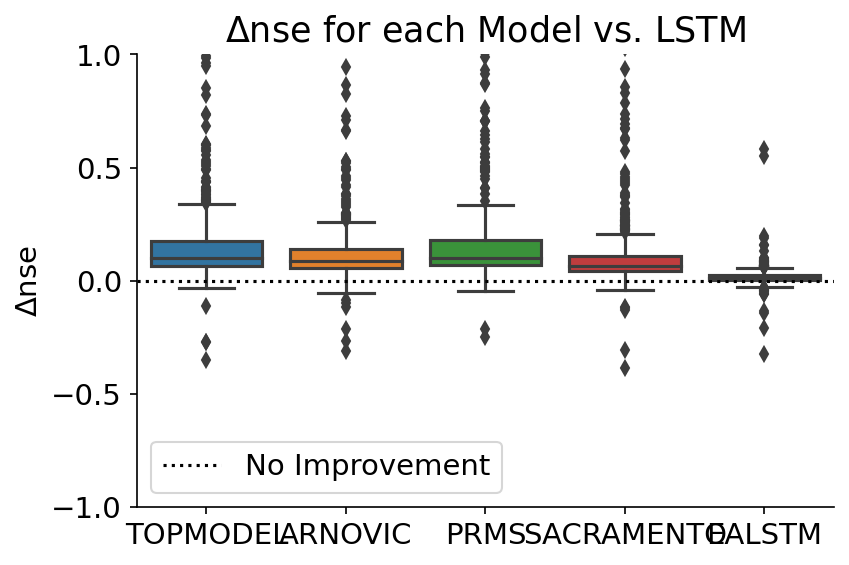

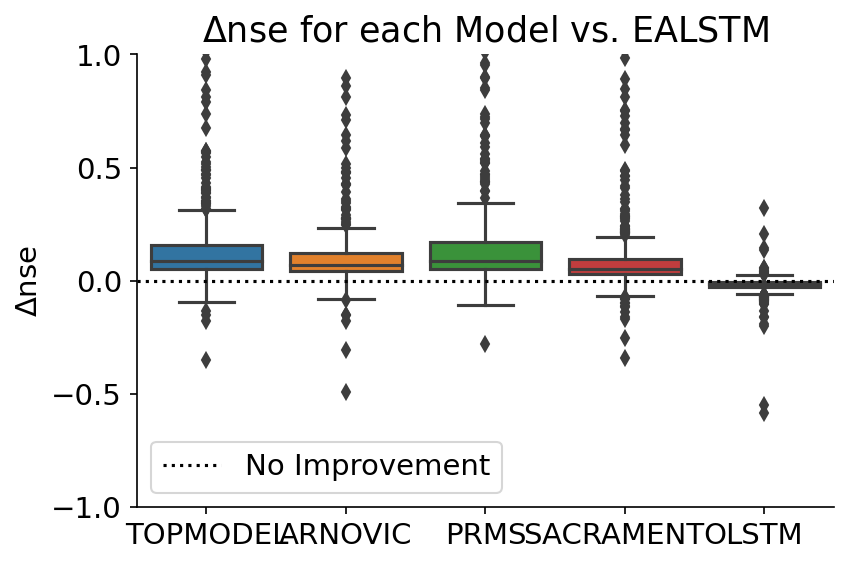

In [36]:
f, ax = plt.subplots()
boxplot_deltas(lstm_delta, metric="nse")
f, ax = plt.subplots()
boxplot_deltas(ealstm_delta, metric="nse", ref_model="EALSTM")

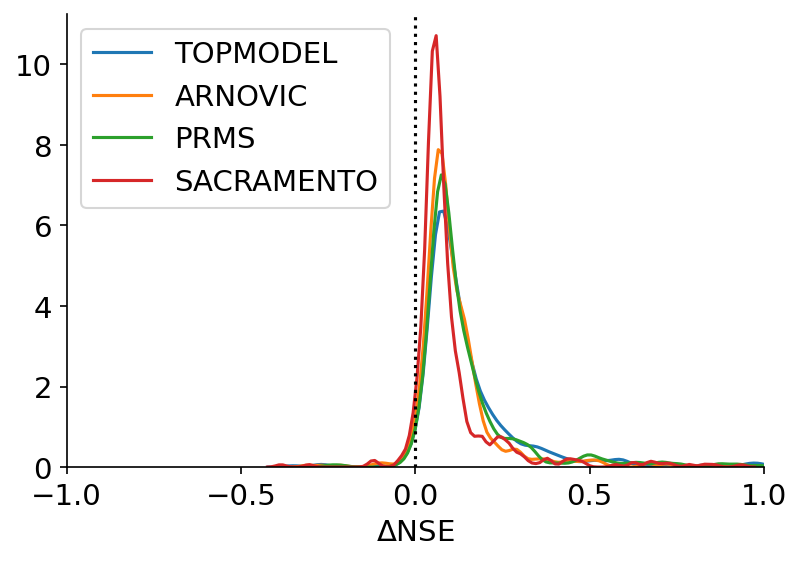

In [37]:
from typing import Tuple

def kde_plot_deltas(delta_df: pd.DataFrame, metric: str = "nse", xlim: Tuple[float] = (-1, 1)):
        kde_kws = {"clip": (-1, 1)}
        hist_kws = {"range": (-1, 1), "density": True}

        f, ax = plt.subplots()
        [
            sns.distplot(delta_df[metric][c], ax=ax, kde_kws=kde_kws, hist_kws=hist_kws, hist=False, label=c) 
            for c in delta_df[metric].columns if c != "EALSTM"
        ]
        ax.set_xlim((-1, 1))
        ax.axvline(0, ls=":", color="k")
        ax.set_xlabel("$\Delta$NSE")
        ax.legend()
        sns.despine()
        
        
kde_plot_deltas(lstm_delta, metric="nse", xlim=(-1, 1))

In [38]:
lstm_seasonal_dfs = {}
for season in ["DJF", "MAM", "JJA", "SON"]:
    lstm_seasonal_dfs[season] = seasonal_deltas[season]["LSTM"]["nse"]
    
ealstm_seasonal_dfs = {}
for season in ["DJF", "MAM", "JJA", "SON"]:
    ealstm_seasonal_dfs[season] = seasonal_deltas[season]["EALSTM"]["nse"]

In [39]:
display(lstm_seasonal_dfs["DJF"].head())
display(lstm_seasonal_dfs["MAM"].head())

,TOPMODEL,ARNOVIC,PRMS,SACRAMENTO,EALSTM
station_id,,,,,
1001,0.261634,0.218237,0.195950,0.177985,0.028467
2001,0.315793,0.203352,0.198490,0.210352,0.029534
2002,0.202082,0.184866,0.209287,0.177524,0.025406
3003,0.116133,0.113429,0.140705,0.119141,0.048408
4001,0.211275,0.095807,0.149318,0.103828,0.032401


,TOPMODEL,ARNOVIC,PRMS,SACRAMENTO,EALSTM
station_id,,,,,
1001,0.197531,0.163637,0.144465,0.128171,-0.000377
2001,0.200966,0.143340,0.141249,0.137527,-0.015521
2002,0.196168,0.183736,0.199590,0.167029,-0.001628
3003,0.097970,0.116204,0.104269,0.096239,0.031136
4001,0.110857,0.076516,0.179965,0.114692,0.026508


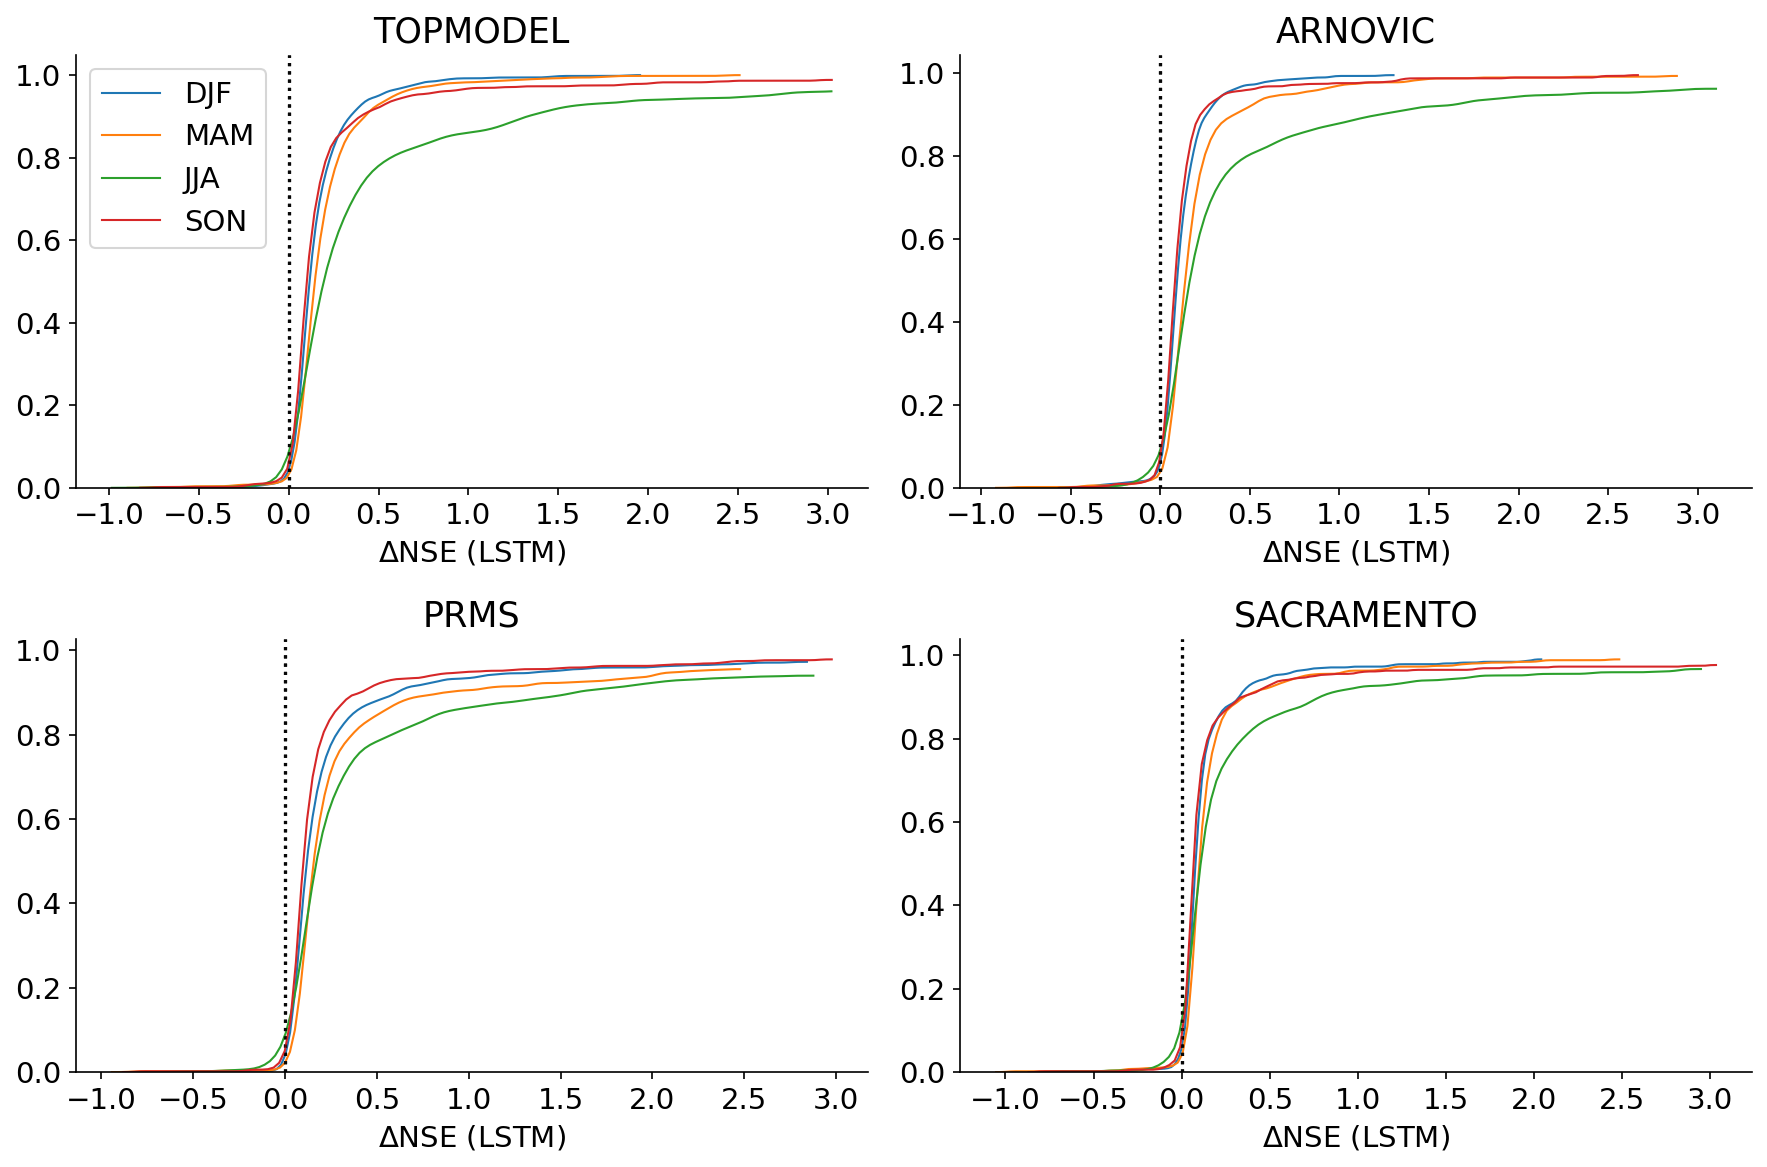

In [40]:
from typing import DefaultDict

# LSTM
metric = "nse"
ref_model = "LSTM"

def plot_seasonal_ecdfs(seasonal_deltas: DefaultDict, metric: str = "nse", ref_model: str = "LSTM", clip: Tuple[float] = (-1, 3)):
    fig, axs = plt.subplots(2, 2, figsize=(6*2, 4*2))

    for ix, model in enumerate(["TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]):
        ax = axs[np.unravel_index(ix, (2, 2))]
        for season in ["DJF", "MAM", "JJA", "SON"]:
            sns.distplot(
                seasonal_deltas[season][ref_model][metric].loc[:, model].dropna(), 
                label=season, 
                kde_kws = {"clip": (-1, 3), "linewidth":1, "cumulative": True}, 
                hist=False, ax=ax
            )

            ax.axvline(0, ls=":", color="k", alpha=0.6)
            ax.set_xlabel(f"$\Delta${metric.upper()} ({ref_model})")
            ax.set_title(model)
            if ix != 0:
                ax.get_legend().remove()

            sns.despine()

    plt.tight_layout()
    
plot_seasonal_ecdfs(seasonal_deltas, metric="nse", ref_model="LSTM")

In [41]:
# def create_bins(data: pd.Series, n_bins: int=4) -> pd.DataFrame:
#     assert all(np.isfinite(data)), "Weird behaviour with nans. Drop them. `data.dropna()`"
#     # get the groups where greater than zero
#     zero_indexes = data.loc[data < 0].index
#     out_series = pd.concat([
#         pd.qcut(data.loc[data > 0], q=n_bins),
#         pd.Series([pd.Interval(-np.inf, 0) for _ in range((data < 0).sum())], index=zero_indexes).astype("category"),
#     ])
#     out_series.name = "group"
    
#     # ordered categories
#     out_series = out_series.astype("category")
#     out_series = out_series.cat.as_ordered()
#     # create 2 columns of categories and code
#     df = pd.DataFrame({"category": out_series, "code": out_series.cat.codes})

#     return df


def create_custom_binned_data(data) -> pd.DataFrame:
    bins = pd.IntervalIndex.from_tuples([(-np.inf, 0), (0, 0.05), (0.05, 0.1), (0.1, 0.2), (0.2, np.inf)])
    bin_vals = pd.cut(season_deltanse["value"], bins, retbins=False)
    bin_vals = bin_vals.cat.as_ordered()
    bin_codes = bin_vals.cat.codes
    
    df = pd.DataFrame({"category": bin_vals, "code": bin_codes})
    return df

In [42]:
seasonal_deltas["DJF"]["LSTM"]["nse"]
seasonal_deltas["MAM"]["LSTM"]["nse"]
seasonal_deltas["SON"]["LSTM"]["nse"]
dd = seasonal_deltas["JJA"]["LSTM"]["nse"]

# flattened.pivot_table(values=['value'], index="station_id", columns=['variable'], aggfunc=lambda x: x)
all_season_deltanse = []
for season in ["DJF", "MAM", "JJA", "SON"]:
    dd = seasonal_deltas[season]["LSTM"]["nse"]
    flattened = dd.reset_index().melt(id_vars=["station_id"])
    flattened["season"] = season
    all_season_deltanse.append(flattened)

season_deltanse = pd.concat(all_season_deltanse).dropna()
# season_deltanse.join(create_custom_binned_data(season_deltanse["value"]))
binned_ = create_custom_binned_data(season_deltanse["value"])
season_deltanse["category"] = binned_["category"]
season_deltanse["code"] = binned_["code"]

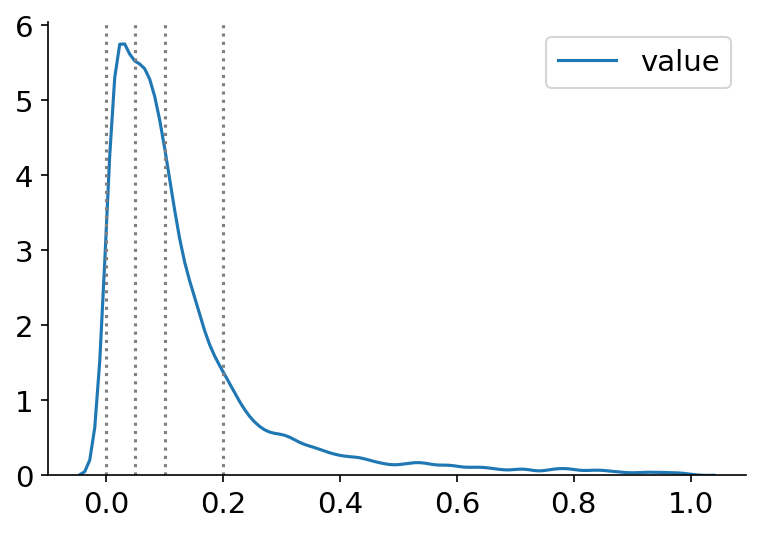

In [43]:
sns.kdeplot(season_deltanse["value"], clip=(0, 1))
ax = plt.gca()
for boundary in season_deltanse["category"].cat.categories.left[1:]:
    ax.axvline(boundary, ls=":", alpha=1, color="grey")
    
sns.despine()

In [44]:
C = season_deltanse.groupby(["category", "season"]).count()["code"].reset_index().rename(dict(code="count"), axis=1)
C["pct"] = (C["count"] / C.groupby("season").sum()["count"].loc[C["season"]].values) * 100
C["season"] = pd.Categorical(C["season"], ordered=True)
C["season"] = C["season"].cat.reorder_categories(["SON", "DJF", "MAM", "JJA"])

C.head()

,category,season,count,pct
0,"(-inf, 0.0]",DJF,176,6.425703
1,"(-inf, 0.0]",JJA,310,11.317999
2,"(-inf, 0.0]",MAM,144,5.257393
3,"(-inf, 0.0]",SON,238,8.689303
4,"(0.0, 0.05]",DJF,802,29.280759


In [45]:
# print(dir(pd.Categorical(C["season"], ordered=True)))

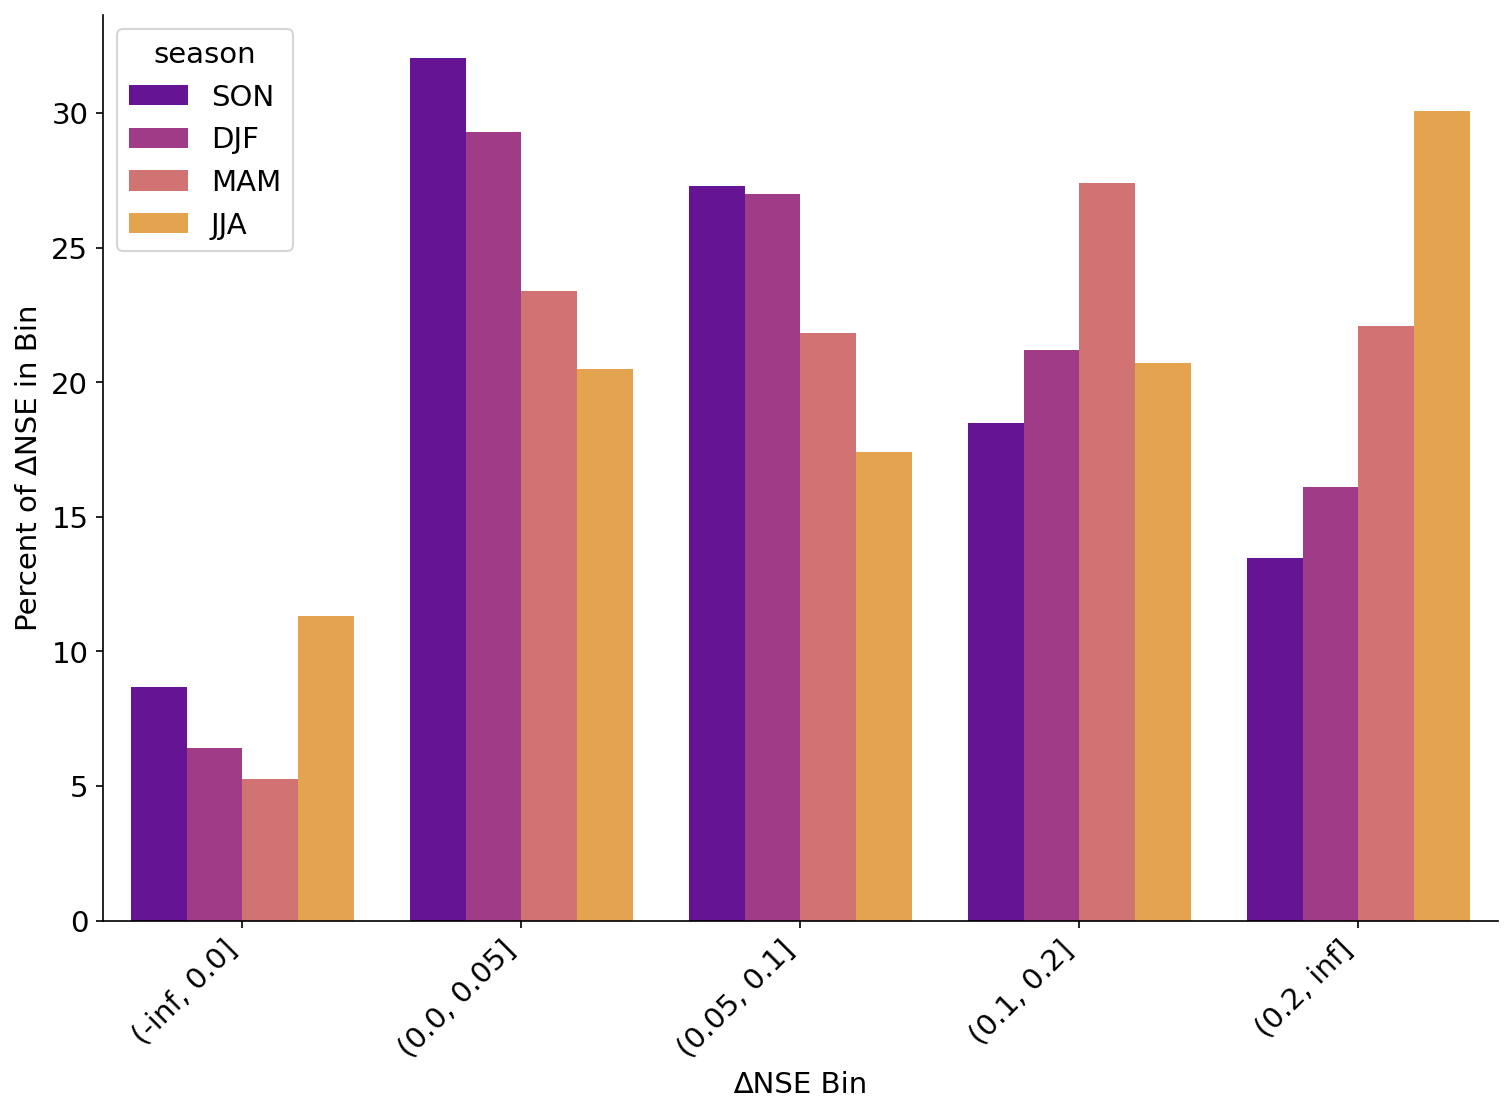

In [46]:
f, ax = plt.subplots(figsize=(12, 8))
sns.barplot(y="pct", x="category", hue="season", data=C, palette="plasma", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right");
ax.set_ylabel("Percent of ∆NSE in Bin")
ax.set_xlabel("∆NSE Bin")
sns.despine()

In [47]:
flattened.set_index("station_id").stack

<bound method DataFrame.stack of             variable     value season
station_id                           
1001        TOPMODEL  0.049801    SON
2001        TOPMODEL  0.034628    SON
2002        TOPMODEL  0.009740    SON
3003        TOPMODEL  0.023367    SON
4001        TOPMODEL  0.283211    SON
...              ...       ...    ...
101002        EALSTM  0.018633    SON
101005        EALSTM  0.028437    SON
102001        EALSTM  0.023724    SON
106001        EALSTM  0.019825    SON
107001        EALSTM -0.004121    SON

[3335 rows x 3 columns]>

# Groundwater

In [48]:
from typing import Dict


def plot_static_feature_ordered_scatter(
    delta_data: Dict[str, pd.DataFrame],
    metric: str = "nse", 
    ylim: Tuple[float] = (-0.5, 1.6), 
    feature: str = "aridity",
    kwargs: Dict = {},
):
    data = delta_data[metric].join(static[feature].to_dataframe())

    f, axs = plt.subplots(2, 2)

    for ix, model in enumerate(["TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]):
        ax_ix = np.unravel_index(ix, (2, 2))
        ax = axs[ax_ix]
        sorted_index = data[model].sort_values().index
        s = ax.scatter(
            np.arange(len(data[model])), 
            data[model].sort_values().loc[sorted_index], 
            c=data[feature].loc[sorted_index],
            **kwargs
        )
        ax.axhline(ls=":", color="k", alpha=0.5, label="No Improvement")
        ax.set_title(f"{model} Delta {metric.upper()}")
        ax.set_ylim(ylim)
        ax.set_xticklabels([])
        ax.set_xticks([])

        sns.despine()
        if ax_ix[1] == 0:
            ax.set_ylabel("$\Delta$NSE")
        else:
            ax.set_yticklabels([])
            ax.set_yticks([])
        if ax_ix[0] == 1:
            ax.set_xlabel("Basin")

    
    # colorbar
    f.tight_layout()
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = f.colorbar(s, cax=cbar_ax)
    cbar.set_label(feature.capitalize())

    
def plot_static_feature_scatter(
    delta_data: Dict[str, pd.DataFrame],
    metric: str = "nse", 
    ylim: Tuple[float] = (0, 1), 
    xlim: Tuple[float] = (-0.5, 1.6), 
    feature: str = "aridity",
    kwargs: Dict = {},
):
    data = delta_data[metric].join(static[feature].to_dataframe())

    f, axs = plt.subplots(2, 2)

    for ix, model in enumerate(["TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]):
        ax_ix = np.unravel_index(ix, (2, 2))
        ax = axs[ax_ix]
        sorted_index = data[model].index
        s = ax.scatter(
            data[model].loc[sorted_index], 
            data[feature].loc[sorted_index],
            c=data[feature].loc[sorted_index],
            **kwargs
        )
        ax.axvline(0, ls=":", color="k", alpha=0.5, label="No Improvement")
        ax.set_title(f"{model} Delta {metric.upper()}")
        ax.set_ylim(ylim)
        ax.set_xlim(xlim)
        sns.despine()
        if ax_ix[1] == 0:
            ax.set_ylabel(f"{feature}")
        else:
            ax.set_yticklabels([])
            ax.set_yticks([])
        if ax_ix[0] == 1:
            ax.set_xlabel("$\Delta$NSE")

    # colorbar
    f.tight_layout()
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = f.colorbar(s, cax=cbar_ax)
    cbar.set_label(feature.capitalize())
    

In [49]:
# plot_static_feature_ordered_scatter(lstm_delta, metric="nse", feature="baseflow_index", kwargs={"s": None, "marker":"o", "s": 7})

In [50]:
# plot_static_feature_scatter(lstm_delta, metric="nse", feature="baseflow_index", kwargs={"vmin":None, "vmax":None, "s": 7})
# plot_static_feature_scatter(lstm_delta, metric="nse", feature="area")

### Discretize the DeltaNSE

In [51]:
# get the continuous static features with few nans
float_static = static.to_dataframe().loc[:, static.to_dataframe().dtypes == "float64"]
float_static = float_static.loc[:, ~(float_static.isnull().mean() > 0.25)]



def create_bins(data: pd.Series, n_bins: int=4) -> pd.DataFrame:
    # get the groups where greater than zero
    zero_indexes = data.loc[data < 0].index
    out_series = pd.concat([
        pd.qcut(data.loc[data > 0], q=n_bins),
        pd.Series([pd.Interval(-np.inf, 0) for _ in range((data < 0).sum())], index=zero_indexes).astype("category"),
    ])
    out_series.name = "group"
    
    # ordered categories
    out_series = out_series.astype("category")
    out_series = out_series.cat.as_ordered()
    # create 2 columns of categories and code
    df = pd.DataFrame({"category": out_series, "code": out_series.cat.codes})

    return df



def create_model_delta_bins_with_static(
    delta_data = lstm_delta,
    metric = "nse",
    model = "TOPMODEL",
    static_variable = "baseflow_index"
):
    model_delta = delta_data[metric][model]
    binned = create_bins(model_delta)
    
    # join to static data
    data = binned.join(float_static[static_variable])

    return data


def boxplot_discretized_delta_nse(data: pd.DataFrame, static_variable: str, model: str, ax, swarm: bool = True, swarm_kwargs: Dict = {"size": 2}):
    assert all(np.isin(["category", static_variable], data.columns)), "calculate discretized bins with `create_model_delta_bins_with_static` function"
    
    sns.boxplot(x="category", y=static_variable, data=data, ax=ax)
    if swarm:
        sns.swarmplot(x="category", y=static_variable, data=data, color=".25", ax=ax, **swarm_kwargs)

    # prettier labels
    labels = []
    for category in data["category"].cat.categories:
        labels.append(f"{category.left:.2f} > x < {category.right:.2f}")

    ax.set_xticklabels(labels, rotation = 45, ha="right")
    ax.set_xlabel("$\Delta$NSE Bin")
    ax.set_ylabel(static_variable)
    ax.set_title(f"{model} Discretized $\Delta$NSE")
    sns.despine()
    

delta_data = lstm_delta
metric = "nse"
model = "TOPMODEL"
static_variable = "baseflow_index"

# f, ax = plt.subplots()
# data = create_model_delta_bins_with_static(lstm_delta, metric, model, static_variable)
# boxplot_discretized_delta_nse(data, static_variable, model, ax=ax)

In [52]:
# join all into one big plot
d = lstm_delta["nse"].drop("EALSTM", axis=1).melt()
index = np.tile(lstm_delta["nse"].index, 4)
d.index = index

binned = create_bins(d.value, n_bins=6).join(float_static["baseflow_index"])

# f, ax = plt.subplots()
# boxplot_discretized_delta_nse(binned, "variable", "All Models", ax=ax, swarm=False)
# binned

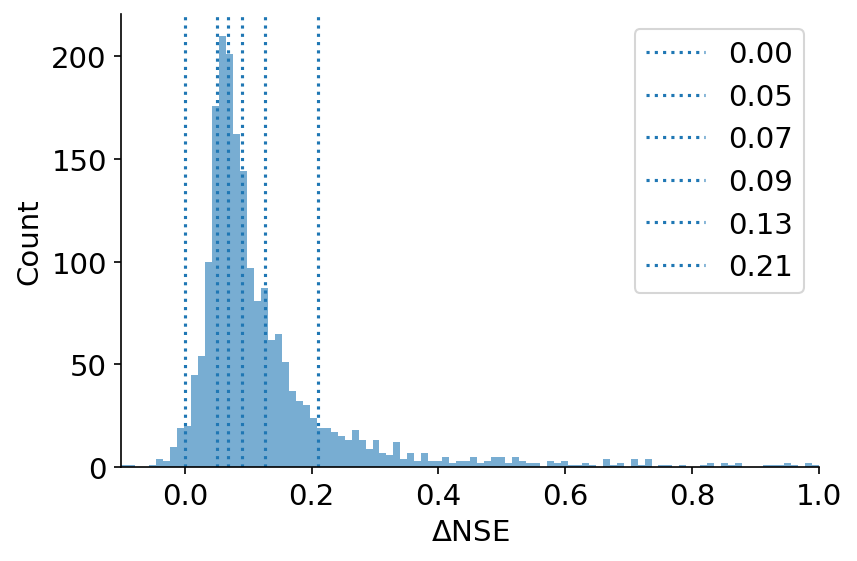

In [53]:
# histogram of all data from 
out = lstm_delta["nse"].drop("EALSTM", axis=1).melt()
index = np.tile(lstm_delta["nse"].index, 4)
out.index = index


# PLOT HIST
plt.hist(out["value"], bins=100, range=(-0.1, 1), alpha=0.6);
cutoffs = np.array(binned["category"].cat.categories.right)[:-1]
ax = plt.gca()
for c in cutoffs:
    ax.axvline(c, ls=":", label=f"{c:.2f}")
ax.legend()
ax.set_xlim(-0.1, 1)

ax.set_xlabel("$\Delta$NSE")
ax.set_ylabel("Count")

sns.despine()

In [54]:
create_bins(float_static["baseflow_index"], n_bins=6)

,category,code
station_id,,
1001,"(0.44, 0.51]",1
2001,"(0.51, 0.56]",2
2002,"(0.44, 0.51]",1
3003,"(0.239, 0.44]",0
4001,"(0.61, 0.71]",4
...,...,...
101002,"(0.61, 0.71]",4
101005,"(0.61, 0.71]",4
102001,"(0.44, 0.51]",1


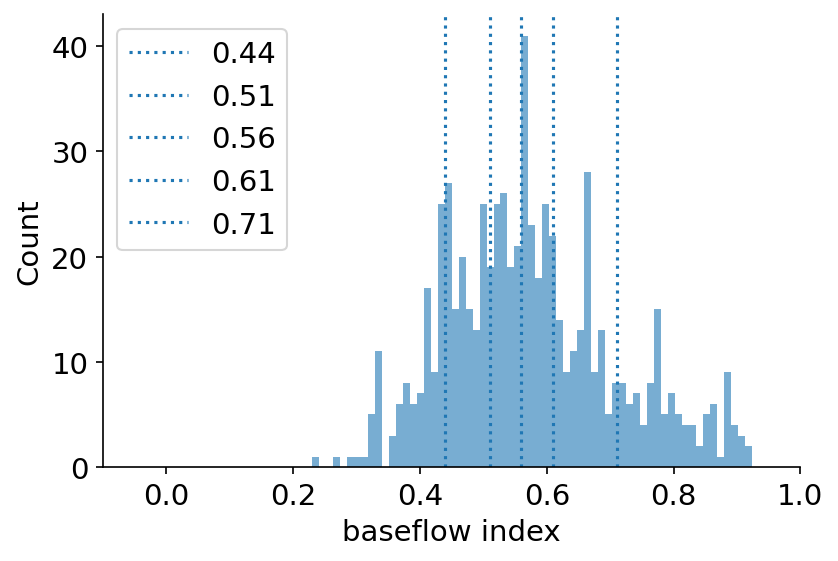

In [55]:
binned = create_bins(float_static["baseflow_index"], n_bins=6).join(float_static["baseflow_index"])

# PLOT HIST
plt.hist(binned["baseflow_index"], bins=100, range=(-0.1, 1), alpha=0.6);
cutoffs = np.array(binned["category"].cat.categories.right)[:-1]
ax = plt.gca()
for c in cutoffs:
    ax.axvline(c, ls=":", label=f"{c:.2f}")
ax.legend()
ax.set_xlim(-0.1, 1)

ax.set_xlabel("baseflow index")
ax.set_ylabel("Count")

sns.despine()

In [56]:
# # TO PLOT EACH MODEL SEPARATELY

# delta_data = lstm_delta
# metric = "nse"
# # model = "TOPMODEL"
# static_variable = "baseflow_index"

# f, axs = plt.subplots(2, 2, figsize=(6*1.5, 4*1.5))
# for ix, model in enumerate(["TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]):
#     ax_ix = np.unravel_index(ix, (2, 2))
#     ax = axs[ax_ix]

#     data = create_model_delta_bins_with_static(lstm_delta, metric, model, static_variable)
#     boxplot_discretized_delta_nse(data, static_variable, model, ax=ax, swarm_kwargs={"size": 2})
    
#     fig.tight_layout()

In [57]:
# lstm_errors

### SCATTER Plot

In [58]:
from typing import Callable

# SPLINE FUNCTIONS
from typing import Union
def sort_values_by_x(x: Union[np.ndarray, pd.Series], y: Union[np.ndarray, pd.Series]) -> Union[np.ndarray, pd.Series]:
    sort = np.argsort(x)
    try:
        x = x.iloc[sort]
        y = y.iloc[sort]
    except AttributeError:
        x = x[sort]
        y = y[sort]
    return x, y


def strict_increasing(x: pd.Series, y: pd.Series) -> Tuple[pd.Series]:
    # TODO: convert to using np.argsort to maintain x,y pairing
    x, y = sort_values_by_x(x, y)

    strictly_increasing_x = [True]
    strictly_increasing_x.extend(np.diff(x) > 0)
    x_inc = x[strictly_increasing_x]
    y_inc = y[strictly_increasing_x]
    
    return x_inc, y_inc


def return_finite_only(x: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray]:
    x = x[np.isfinite(x) & np.isfinite(y)]
    y = y[np.isfinite(x) & np.isfinite(y)]
    return x, y


def cubic_spline(x: pd.Series, y: pd.Series) -> Callable:
    from scipy.interpolate import CubicSpline
    # https://stackoverflow.com/a/43613728/9940782
    # dropnans
    x, y = return_finite_only(x, y)
    
    # strictly increasing
    x, y = strict_increasing(x, y)
    
    # fit cubic spline
    cs = CubicSpline(x, y, bc_type="natural")
    return cs


def gaussian_kernel_smoother(x: pd.Series, y: pd.Series, sigma: float = 2, dropnan: bool = False) -> Tuple[np.ndarray]:
    from scipy import ndimage
    if dropnan:
        x, y = return_finite_only(x, y)

    # https://stackoverflow.com/a/32905652/9940782
    x_g1d = ndimage.gaussian_filter1d(x, sigma, mode="reflect")
    y_g1d = ndimage.gaussian_filter1d(y, sigma, mode="reflect")
    
    return x_g1d, y_g1d


def univariate_spline(x: pd.Series, y: pd.Series, **kwargs) -> Callable:
    """
    kwargs:
        k: Degree of the smoothing spline
        s: smoothing parameter (often requires fitting)
    """
    from scipy import interpolate
    x, y = return_finite_only(x, y)

    # strictly increasing
    x, y = strict_increasing(x, y)

    spl = interpolate.UnivariateSpline(x, y, **kwargs)
    
    return spl


def smooth_lowess(x, y, kwargs: Dict = {}) -> Tuple[pd.Series]:
    from statsmodels.nonparametric.smoothers_lowess import lowess

    # wrapper for statsmodels lowess
    try:
        smooth_y = lowess(y, x, return_sorted=False, **kwargs)
    except AttributeError:
        x, y = x.values.flatten(), y.values.flatten()
        smooth_y = lowess(y, x, return_sorted=False, **kwargs)
    
    df = x.rename("x").to_frame()
    df["y"] = smooth_y
    df = df.dropna().sort_values("x")
    return df["x"], df["y"]

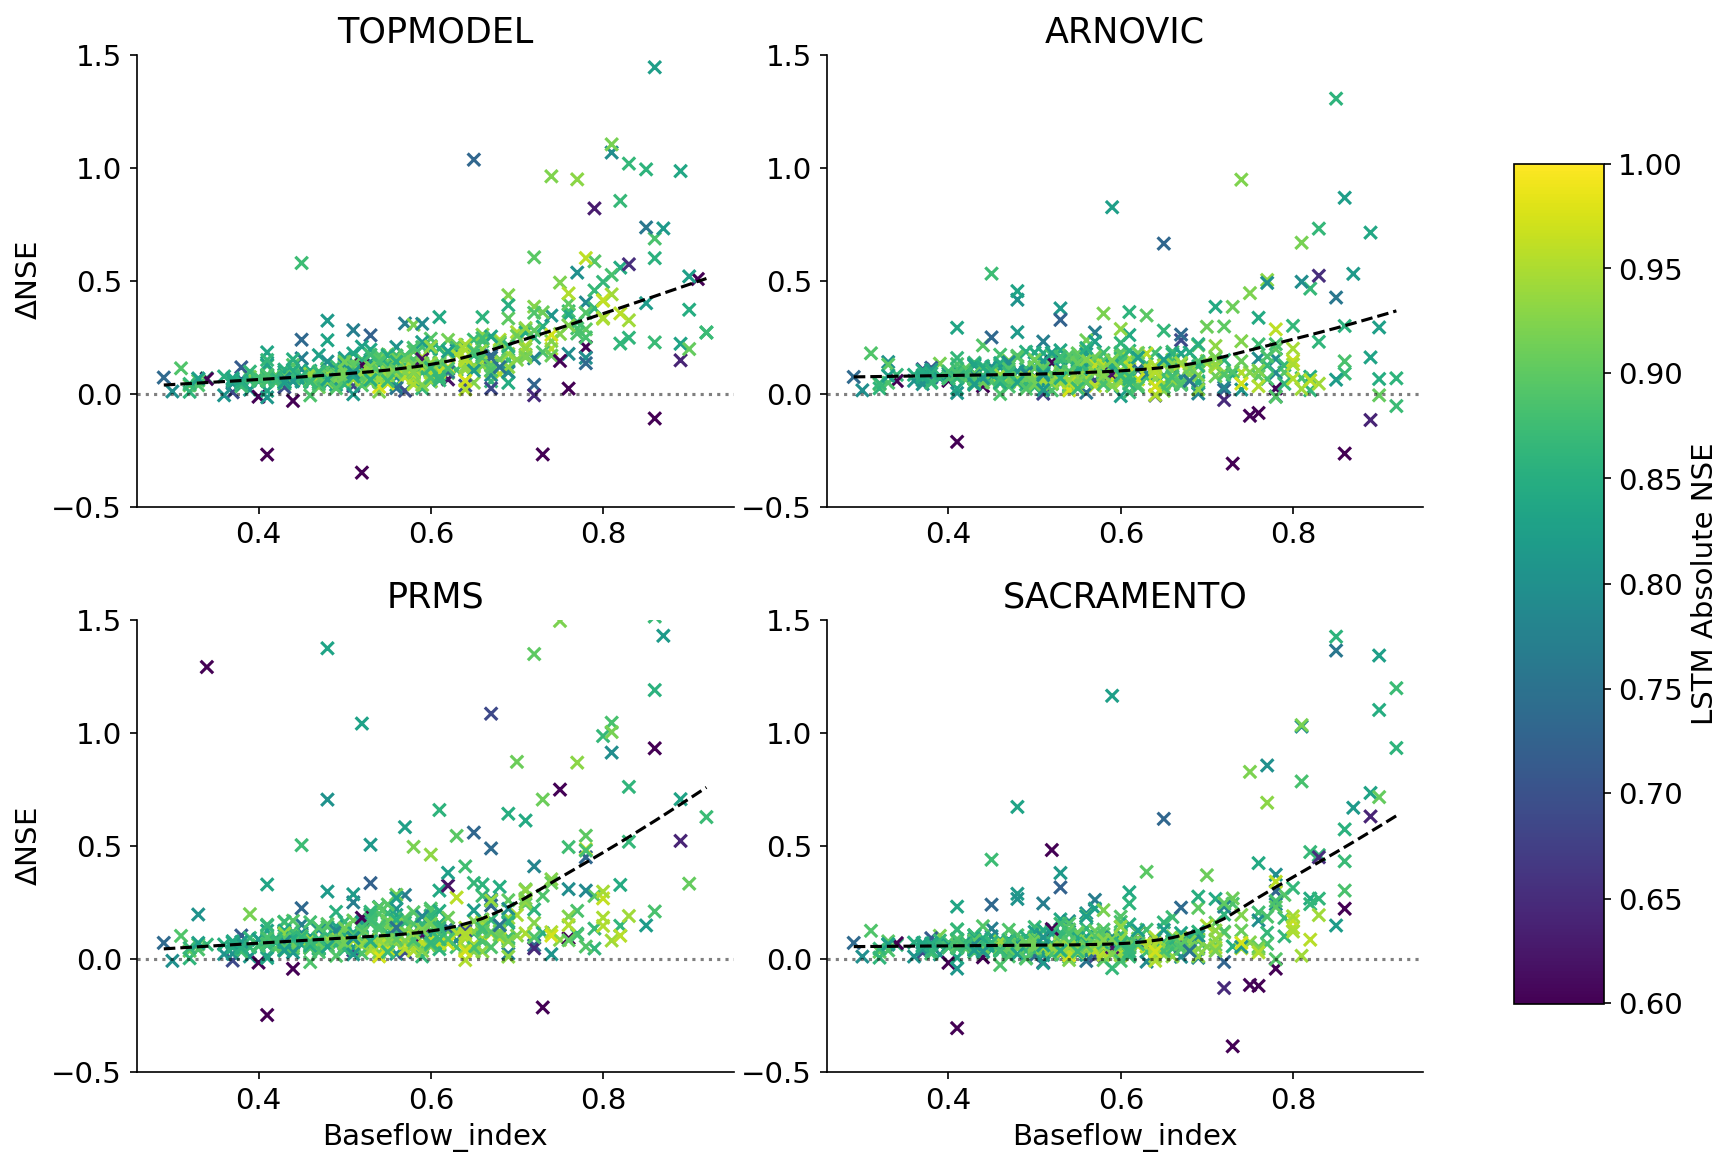

In [59]:
from typing import Optional


# [v for v in static.data_vars]
delta_data = lstm_delta["nse"]
feature = "baseflow_index"
metric = "nse"
kwargs = {"vmin": 0.6, "vmax": 1, "marker": "x"}


def plot_scatter_delta_nse_static(
    delta_data: pd.DataFrame, 
    metric: str = "nse", 
    feature: str = "baseflow_index", 
    ylim: Tuple[Optional[float]] = (None, None),
    absolute_data: pd.DataFrame = None,
    spline: bool = True,
    spline_kwargs: Dict = {"s": 9, "k": 3},
    kwargs: Dict = {}
):
    models = ["TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]
    assert all(np.isin(models, delta_data[metric].columns))
    # get X and y variables
    data = delta_data[metric].join(static[feature].to_dataframe())
    x = data[feature].astype("float64")
    
    # get the color variable (z)
    if absolute_data is not None:
        # set the color to be the absolute NSE for that basin (LSTM/EALSTM)
        absolute_data = absolute_data.loc[data.index, metric].astype("float64")
        
    f, axs = plt.subplots(2, 2, figsize=(6*2, 4*2))

    for ix, model in enumerate(models):
        y = data[model].astype("float64")

        ax = axs[np.unravel_index(ix, (2, 2))]
        s = ax.scatter(
            x, y,
            c=data[feature] if absolute_data is None else absolute_data,
            **kwargs
        )
        ax.axhline(ls=":", color="k", alpha=0.5, label="No Improvement")
        ax.set_title(f"{model}")
        ax.set_ylim(ylim)

        if np.unravel_index(ix, (2, 2))[1] == 0:
            ax.set_ylabel(f"$\Delta${metric.upper()}")
        if np.unravel_index(ix, (2, 2))[0] == 1:
            ax.set_xlabel(f"{feature.capitalize()}")
            
        if spline:
            sm_x, sm_y = smooth_lowess(x, y)
            ax.plot(sm_x, sm_y, c="k", ls="--")
        sns.despine()

    # colorbar
    f.tight_layout()
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = f.colorbar(s, cax=cbar_ax)
    cbar.set_label(feature.capitalize() if absolute_data is None else f"LSTM Absolute NSE")
    
    return f, axs, data
    

feature = "baseflow_index"
f, axs, data = plot_scatter_delta_nse_static(
    lstm_delta, "nse", feature, 
    absolute_data=lstm_metric_df,   # None
    kwargs=kwargs, 
    spline=True,
    spline_kwargs=dict(k=2, s=100),
    ylim=(-0.5, 1.5),
)

In [60]:
d = static["baseflow_index"].to_dataframe().join(lstm_metric_df["nse"].rename("LSTM")).join(ealstm_metric_df["nse"].rename("EALSTM"))
d.head()


,baseflow_index,LSTM,EALSTM
station_id,,,
1001,0.49,0.876090,0.871396
2001,0.56,0.796159,0.781072
2002,0.45,0.799168,0.781357
3003,0.40,0.878744,0.843745
4001,0.69,0.872644,0.854027


### Fit splines ...

In [61]:
# http://www.science.smith.edu/~jcrouser/SDS293/labs/lab13-py.html
# https://www.analyticsvidhya.com/blog/2018/03/introduction-regression-splines-python-codes/
# https://stackoverflow.com/questions/51321100/python-natural-smoothing-splines

from patsy import dmatrix, build_design_matrices
import statsmodels.api as sm

bfi = d.dropna()["baseflow_index"]
X = dmatrix("bs(x, include_intercept=True, knots=[ 0.3, 0.4, 0.6, 0.8, 0.9])", data=dict(x=bfi))

w = np.ones(6)
w = w / w.sum(axis=0, keepdims=1)

y = d.dropna()["LSTM"].values.reshape(-1, 1)
fit = sm.GLM(y, X).fit()
params = fit.params

# dmatrix(X.design_info, data=dict(lstm=np.linspace(0.21, 0.89, 10)))
# X

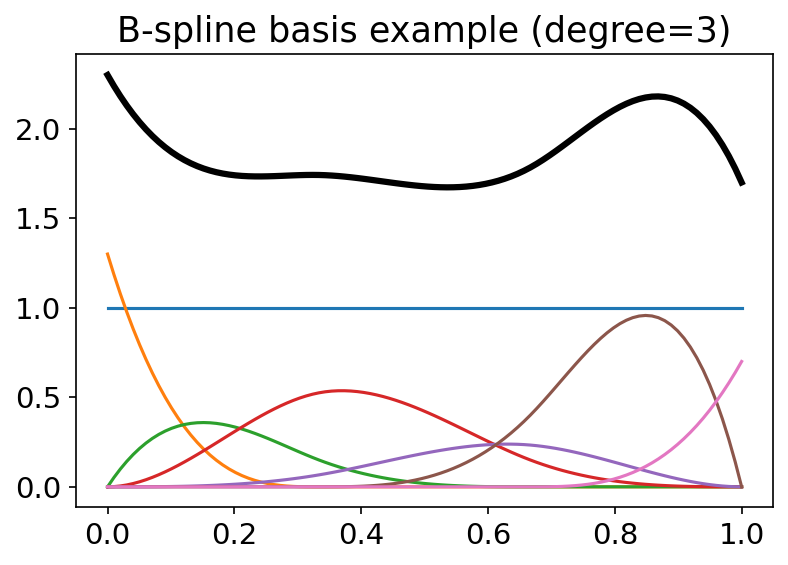

In [62]:
import matplotlib.pyplot as plt
plt.title("B-spline basis example (degree=3)");
x = np.linspace(0., 1., 100)
y = dmatrix("bs(x, df=6, degree=3, include_intercept=True)", {"x": x})
b = np.array([1, 1.3, 0.6, 0.9, 0.4, 1.6, 0.7])

# b = params
# x = lstm
# y = X

plt.plot(x, y*b);
plt.plot(x, np.dot(y, b), color='k', linewidth=3);

In [63]:
d = static["baseflow_index"].to_dataframe().join(lstm_metric_df["nse"].rename("LSTM")).join(ealstm_metric_df["nse"].rename("EALSTM"))

d = nse_df.join(static["baseflow_index"].to_dataframe())
d = d.dropna()
d.head()

,PRMS,Sacramento,TOPMODEL,VIC,Name,LSTM,EALSTM,baseflow_index
1001,0.786218,0.805396,0.754303,0.766521,Wick at Tarroul,0.876090,0.871396,0.49
2001,0.686722,0.699972,0.655162,0.685077,Helmsdale at Kilphedir,0.796159,0.781072,0.56
2002,0.683937,0.697952,0.691850,0.681148,Brora at Bruachrobie,0.799168,0.781357,0.45
3003,0.793153,0.805893,0.806642,0.799981,Oykel at Easter Turnaig,0.878744,0.843745,0.40
4001,0.777022,0.792738,0.724438,0.818019,Conon at Moy Bridge,0.872644,0.854027,0.69


Text(0.5, 0, 'Aridity')

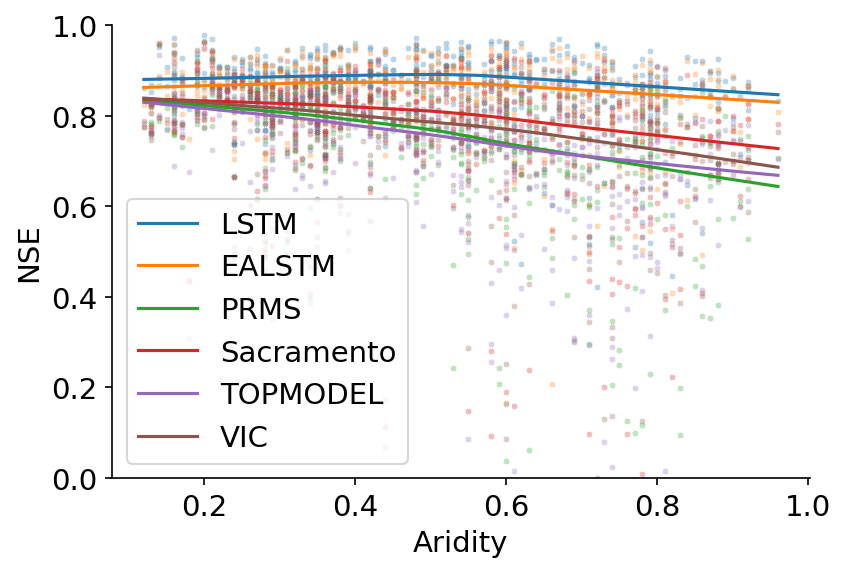

In [64]:
def plot_smooth_line(df: pd.DataFrame, feature: str, model: str, ax):
    px, py = smooth_lowess(df[feature], df[model])
    ax.plot(px, py, label=model, ls="-")
    return ax



def plot_scatter_lowess_feature_nse(feature: str):
    d = nse_df.join(static[feature].to_dataframe()).dropna()
    
    alpha_scatter = 0.3
    s = 4

    f, ax = plt.subplots()
    ax.scatter(d[feature], d["LSTM"], color=sns.color_palette()[0], marker="x", alpha=alpha_scatter, s=s)
    ax = plot_smooth_line(df=d, feature=feature, model="LSTM", ax=ax)

    ax.scatter(d[feature], d["EALSTM"], color=sns.color_palette()[1], marker="x", alpha=alpha_scatter, s=s)
    ax = plot_smooth_line(df=d, feature=feature, model="EALSTM", ax=ax)

    if "PRMS" in d.columns:
        ax.scatter(d[feature], d["PRMS"], color=sns.color_palette()[2], marker="x", alpha=alpha_scatter, s=s)
        ax = plot_smooth_line(df=d, feature=feature, model="PRMS", ax=ax)

        ax.scatter(d[feature], d["Sacramento"], color=sns.color_palette()[3], marker="x", alpha=alpha_scatter, s=s)
        ax = plot_smooth_line(df=d, feature=feature, model="Sacramento", ax=ax)

        ax.scatter(d[feature], d["TOPMODEL"], color=sns.color_palette()[4], marker="x", alpha=alpha_scatter, s=s)
        ax = plot_smooth_line(df=d, feature=feature, model="TOPMODEL", ax=ax)

        ax.scatter(d[feature], d["VIC"], color=sns.color_palette()[5], marker="x", alpha=alpha_scatter, s=s)
        ax = plot_smooth_line(df=d, feature=feature, model="VIC", ax=ax)

    ax.set_xlabel(feature)
    ax.set_ylabel("NSE")
    ax.set_ylim(0, 1)
    ax.legend()
    sns.despine()
    return ax

    
ax = plot_scatter_lowess_feature_nse("aridity")
ax.set_xlabel("Aridity")

Text(0.5, 0, 'Baseflow Index')

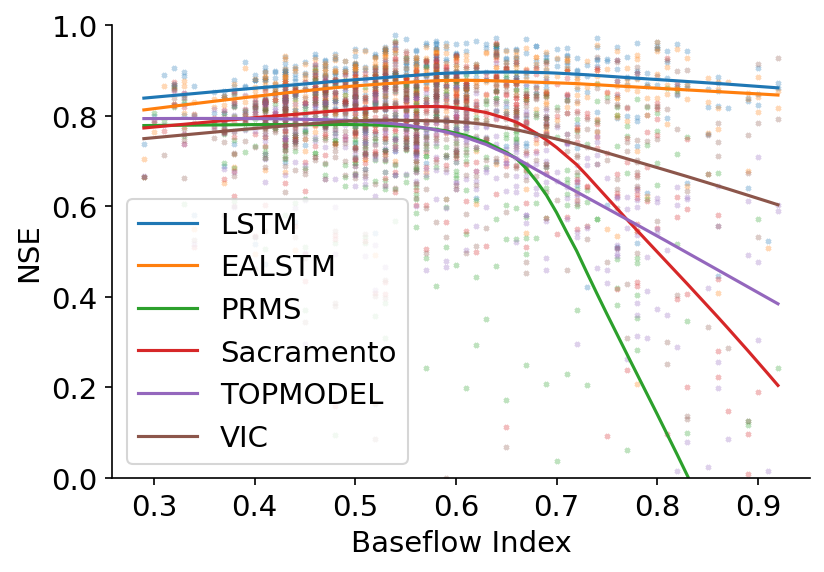

In [65]:
ax = plot_scatter_lowess_feature_nse("baseflow_index")
ax.set_xlabel("Baseflow Index")

# Calculate Runoff Coefficient

In [66]:
def assign_wateryear(dt):
    """https://stackoverflow.com/a/52615358/9940782"""
    dt = pd.Timestamp(dt)
    if dt.month >= 10:
        return(pd.datetime(dt.year+1,1,1).year)
    else:
        return(pd.datetime(dt.year,1,1).year)

ds_wy = ds.assign_coords(wy=("time", [assign_wateryear(dt) for dt in ds.time.values]))
lstm_preds_wy = lstm_preds.assign_coords(wy=("time", [assign_wateryear(dt) for dt in lstm_preds.time.values]))

In [67]:
wy_sum = ds_wy.groupby("wy").sum(dim="time")
runoff_coeff_obs = (wy_sum["discharge_spec"] / wy_sum["precipitation"]).mean("wy")
obs_rc = runoff_coeff_obs.to_dataframe("runoff_coeff")
obs_rc.head()

,runoff_coeff
station_id,
1001,0.263388
2001,0.608132
2002,0.355424
3003,0.656335
4001,0.840136


In [68]:
lstm_wy_sum = lstm_preds_wy.groupby("wy").sum(dim="time")
runoff_coeff_sim = (lstm_wy_sum["sim"] / wy_sum["precipitation"].sel(wy=lstm_wy_sum["wy"])).mean("wy")
sim_rc = runoff_coeff_sim.to_dataframe("runoff_coeff")
sim_rc.head()

,runoff_coeff
station_id,
1001,0.569393
2001,0.572132
2002,0.624176
3003,0.728468
4001,0.851075


In [69]:
rc_comparison = obs_rc.rename({"runoff_coeff": "obs",}, axis=1).join(sim_rc.rename({"runoff_coeff": "sim",}, axis=1))

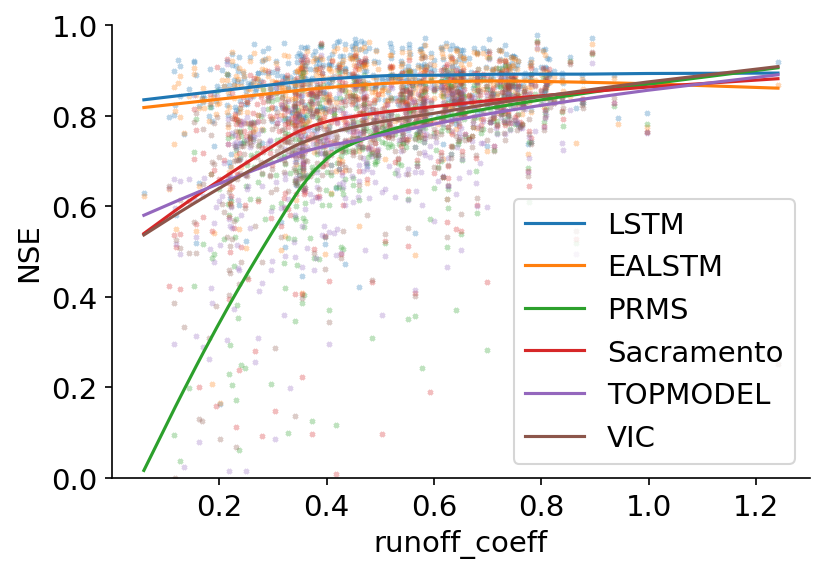

In [70]:
static = static.merge(obs_rc.to_xarray())
plot_scatter_lowess_feature_nse("runoff_coeff")

In [71]:
features_to_test = ["low_q_freq", "Q95", "baseflow_index_ceh", "aridity"]
feature = "low_q_freq"
# f, axs, data = plot_scatter_delta_nse_static(
#     lstm_delta, "nse", feature, 
#     absolute_data=lstm_metric_df,
#     spline_kwargs=dict(k=3, s=100),
#     kwargs=kwargs, ylim=(-0.5, 1.5)
# )

## bin / discretize functions marginalia

In [72]:
# def bin_and_attach_static_features(delta_dict, metric: str = "nse"):
#     # create bin boundaries 
#     cutoff = np.linspace(0, 1, 6)
#     cutoff = np.insert(cutoff, 0, -np.inf)

#     # remove nans from the delta df
#     bin_data = delta_dict["nse"].dropna()

#     # split into groups
#     binned_data = pd.DataFrame(np.digitize(bin_data, cutoff, right=True))
#     binned_data.index = bin_data.index
#     binned_data.columns = bin_data.columns
#     binned_data = binned_data.join(float_static)
    
#     return binned_data, cutoff
    

# def discretize(data, bins):
#     split = np.array_split(np.sort(data), bins)
#     cutoffs = [x[-1] for x in split]
#     cutoffs = cutoffs[:-1]
# #     discrete = np.digitize(data, cutoffs, right=True)
#     return cutoffs

# # binned_data, cutoff = bin_and_attach_static_features(lstm_delta)
# # binned_data.head()

# Table of performances

In [73]:
ealstm_delta_nse = ealstm_delta["nse"]

In [74]:
display(lstm_delta_nse.mean())
display(ealstm_delta_nse.median())

TOPMODEL      0.156288
ARNOVIC       0.173227
PRMS          0.426942
SACRAMENTO    0.198212
EALSTM        0.018665
dtype: float64

TOPMODEL      0.085904
ARNOVIC       0.071856
PRMS          0.086638
SACRAMENTO    0.053325
LSTM         -0.014339
dtype: float64

### % Delta NSE > 0

In [75]:
lstm_delta_nse_ltx = lstm_delta_nse.dropna() #.drop("EALSTM", axis=1)
ealstm_delta_nse_ltx = ealstm_delta_nse.dropna() #.drop("LSTM", axis=1)

In [76]:
# "% Basins where $\Delta$NSE > 0"
latex_df = pd.concat(
    [
        ((lstm_delta_nse_ltx > 0).sum(axis=0) / lstm_delta_nse_ltx.count()).to_frame().rename({0: "LSTM"}, axis=1),
        ((ealstm_delta_nse_ltx > 0).sum(axis=0) / ealstm_delta_nse_ltx.count()).to_frame().rename({0: "EA LSTM"}, axis=1)
    ], axis=1
)
# latex_df.columns = [("% Basins where $\Delta$NSE > 0", "LSTM"), ("% Basins where $\Delta$NSE > 0", "EA LSTM")]
latex_df.mean()

LSTM       0.952896
EA LSTM    0.766409
dtype: float64

In [77]:
print(latex_df.to_latex(float_format="%.2f"))

\begin{tabular}{lrr}
\toprule
{} &  LSTM &  EA LSTM \\
\midrule
TOPMODEL   &  0.98 &     0.95 \\
ARNOVIC    &  0.97 &     0.92 \\
PRMS       &  0.98 &     0.95 \\
SACRAMENTO &  0.96 &     0.89 \\
EALSTM     &  0.87 &      NaN \\
LSTM       &   NaN &     0.13 \\
\bottomrule
\end{tabular}



# Spatial Plots

In [78]:
import geopandas as gpd

assert (data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp").exists(), "Download the natural earth hires from https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip"

world = gpd.read_file(data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp")
uk = world.query("ADM0_A3 == 'GBR'")
uk.head(2)

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry
79,Admin-0 country,0,2,United Kingdom,GB1,1,2,Country,United Kingdom,GBR,...,영국,Verenigd Koninkrijk,Wielka Brytania,Reino Unido,Великобритания,Storbritannien,Birleşik Krallık,Vương quốc Liên hiệp Anh và Bắc Ireland,英国,"MULTIPOLYGON (((-7.24710 55.06932, -7.25674 55..."


In [79]:
matching_stations = list(set(fuse_ds.station_id.values).intersection(set(lstm_preds.station_id.values)))
len(matching_stations)

518

In [80]:
shp_path = data_dir / "CAMELS_GB_DATASET/Catchment_Boundaries/CAMELS_GB_catchment_boundaries.shp"
assert shp_path.exists()

# load in the shapefile
geo_df = gpd.read_file(shp_path)
geo_df['ID_STRING'] = geo_df['ID_STRING'].astype('int')
geo_df.crs = {'init' :'epsg:27700'}  # 4277  27700

In [81]:
delta_df = lstm_delta_nse.reset_index()
# display(delta_df.head())

polygons = False

# create spatial dataframe
assert delta_df['station_id'].dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
delta_gdf = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING').join(delta_df.set_index('station_id'))
).loc[matching_stations]


if not polygons:
    static_df = static.to_dataframe()
    d = static_df[["gauge_lat", "gauge_lon"]]

    points = gpd.GeoSeries(gpd.points_from_xy(d["gauge_lon"], d["gauge_lat"]), index=d.index)
    points.name = "geometry"
    delta_gdf = delta_gdf.drop("geometry", axis=1).join(points)
    delta_gdf.crs = {'init' :'epsg:4326'}


delta_gdf = delta_gdf.to_crs(epsg=4326)

delta_gdf.head()

,ID,SOURCE,VERSION,EXPORTED,TOPMODEL,ARNOVIC,PRMS,SACRAMENTO,EALSTM,geometry
ID_STRING,,,,,,,,,,
43008,43008.0,National River Flow Archive,1.3,2018-02-12,0.599360,0.283863,0.485642,0.342122,0.025110,POINT (-1.88000 51.11000)
43009,43009.0,National River Flow Archive,1.3,2018-02-12,0.063808,0.069805,0.113739,0.056314,0.005437,POINT (-2.26000 50.93000)
43018,43018.0,National River Flow Archive,1.3,2018-02-12,0.443076,0.032464,0.150603,0.029757,0.009630,POINT (-1.99000 50.81000)
43021,43021.0,National River Flow Archive,1.3,2018-02-12,0.356982,-0.014824,0.055493,-0.000257,-0.031312,POINT (-1.78000 50.75000)
84001,84001.0,National River Flow Archive,1.3,2018-02-12,0.049488,0.076842,0.085241,0.044474,0.003527,POINT (-4.31000 55.91000)


(50.0, 59.5)

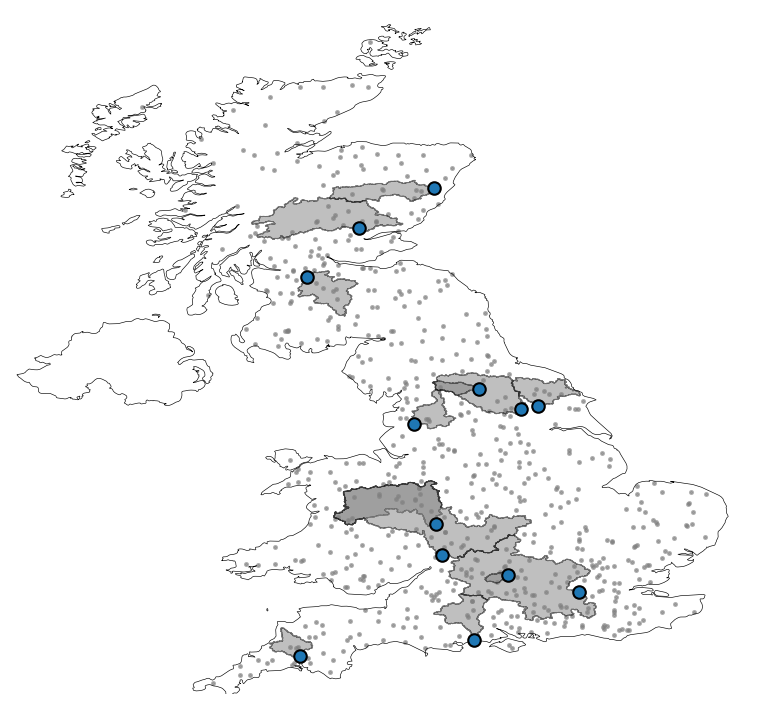

In [82]:
catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]
names = static["gauge_name"].to_dataframe()
poly = geo_df.set_index("ID").loc[catchment_ids].join(names).to_crs(epsg=4326)
pts = gpd.GeoDataFrame(points.loc[catchment_ids]).join(names)

color = None  # sns.color_palette()[0] None

f, ax = plt.subplots(figsize=(15, 6))
points.plot(ax=ax, color="grey", alpha=0.6, markersize=2)
uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)
poly.plot(ax=ax, facecolor="grey",  alpha=0.5, edgecolor="k", linewidth=0.5)  # "gauge_name", cmap="Dark2",
pts.plot(ax=ax, color=color, edgecolor="k")  # "gauge_name", cmap="Dark2", legend=True

ax.axis('off')
ax.set_xlim([-8.2, 2.1])
ax.set_ylim([50, 59.5])


# for x, y, label in zip(pts.geometry.x, pts.geometry.y, pts.name):
#     ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")


In [83]:
# poly["gauge_name"]

In [84]:
def create_spatial_dataframe(delta_df: pd.DataFrame, geo_df: gpd.GeoDataFrame, polygon: bool = False) -> gpd.GeoDataFrame:
    matching_stations = list(set(fuse_ds.station_id.values).intersection(set(lstm_preds.station_id.values)))
    assert delta_df['station_id'].dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
    delta_gdf = gpd.GeoDataFrame(
        geo_df.set_index('ID_STRING').join(delta_df.set_index('station_id'))
    ).loc[matching_stations]
    if not polygons:
        static_df = static.to_dataframe()
        d = static_df[["gauge_lat", "gauge_lon"]]

        points = gpd.GeoSeries(gpd.points_from_xy(d["gauge_lon"], d["gauge_lat"]), index=d.index)
        points.name = "geometry"
        delta_gdf = delta_gdf.drop("geometry", axis=1).join(points)
        delta_gdf.crs = {'init' :'epsg:4326'}


    delta_gdf = delta_gdf.to_crs(epsg=4326)
    
    return delta_gdf

In [85]:
lstm_delta_gdf = create_spatial_dataframe(delta_df=lstm_delta_nse.dropna().reset_index(), geo_df=geo_df)
ealstm_delta_gdf = create_spatial_dataframe(delta_df=ealstm_delta_nse.dropna().reset_index(), geo_df=geo_df)

# lstm_delta_gdf.to_file(data_dir / "RUNOFF/delta_shp_files/lstm.shp")
# ealstm_delta_gdf.to_file(data_dir / "RUNOFF/delta_shp_files/ealstm.shp")

# # write shapefile of locations
# gauge_names = static.to_dataframe()["gauge_name"]
# lstm_delta_gdf[["ID", "geometry"]].join(gauge_names).to_file(data_dir/"RUNOFF/point_shp.shp")

In [86]:
display(lstm_delta_gdf.head())
display(ealstm_delta_gdf.head())

,ID,SOURCE,VERSION,EXPORTED,TOPMODEL,ARNOVIC,PRMS,SACRAMENTO,EALSTM,geometry
ID_STRING,,,,,,,,,,
43008,43008.0,National River Flow Archive,1.3,2018-02-12,0.599360,0.283863,0.485642,0.342122,0.025110,POINT (-1.88000 51.11000)
43009,43009.0,National River Flow Archive,1.3,2018-02-12,0.063808,0.069805,0.113739,0.056314,0.005437,POINT (-2.26000 50.93000)
43018,43018.0,National River Flow Archive,1.3,2018-02-12,0.443076,0.032464,0.150603,0.029757,0.009630,POINT (-1.99000 50.81000)
43021,43021.0,National River Flow Archive,1.3,2018-02-12,0.356982,-0.014824,0.055493,-0.000257,-0.031312,POINT (-1.78000 50.75000)
84001,84001.0,National River Flow Archive,1.3,2018-02-12,0.049488,0.076842,0.085241,0.044474,0.003527,POINT (-4.31000 55.91000)


,ID,SOURCE,VERSION,EXPORTED,TOPMODEL,ARNOVIC,PRMS,SACRAMENTO,LSTM,geometry
ID_STRING,,,,,,,,,,
43008,43008.0,National River Flow Archive,1.3,2018-02-12,0.574250,0.258752,0.460531,0.317011,-0.025110,POINT (-1.88000 51.11000)
43009,43009.0,National River Flow Archive,1.3,2018-02-12,0.058371,0.064368,0.108302,0.050877,-0.005437,POINT (-2.26000 50.93000)
43018,43018.0,National River Flow Archive,1.3,2018-02-12,0.433446,0.022833,0.140973,0.020127,-0.009630,POINT (-1.99000 50.81000)
43021,43021.0,National River Flow Archive,1.3,2018-02-12,0.388294,0.016489,0.086806,0.031055,0.031312,POINT (-1.78000 50.75000)
84001,84001.0,National River Flow Archive,1.3,2018-02-12,0.045961,0.073315,0.081714,0.040948,-0.003527,POINT (-4.31000 55.91000)


The lighter colors are the basins that have a higher delta NSE than the 

In [87]:
bool_wb = xr.open_dataset(data_dir / "RUNOFF/bool_water_balance_20pct.nc")
bool_wb = bool_wb.to_array().isel(variable=0).drop("variable")
wb_stations = bool_wb.where(bool_wb, drop=True).station_id
non_wb_stations = bool_wb.where(~bool_wb, drop=True).station_id
wb_stations

<xarray.DataArray 'station_id' (station_id: 411)>
array([  2001,   4001,   4003, ...,  96002,  97002, 101002])
Coordinates:
  * station_id  (station_id) int64 2001 4001 4003 6007 ... 96002 97002 101002

In [88]:
delta_gdf.loc[np.isin(delta_gdf["ID"], wb_stations.values)].head()

,ID,SOURCE,VERSION,EXPORTED,TOPMODEL,ARNOVIC,PRMS,SACRAMENTO,EALSTM,geometry
ID_STRING,,,,,,,,,,
43008,43008.0,National River Flow Archive,1.3,2018-02-12,0.599360,0.283863,0.485642,0.342122,0.025110,POINT (-1.88000 51.11000)
43009,43009.0,National River Flow Archive,1.3,2018-02-12,0.063808,0.069805,0.113739,0.056314,0.005437,POINT (-2.26000 50.93000)
43018,43018.0,National River Flow Archive,1.3,2018-02-12,0.443076,0.032464,0.150603,0.029757,0.009630,POINT (-1.99000 50.81000)
43021,43021.0,National River Flow Archive,1.3,2018-02-12,0.356982,-0.014824,0.055493,-0.000257,-0.031312,POINT (-1.78000 50.75000)
84001,84001.0,National River Flow Archive,1.3,2018-02-12,0.049488,0.076842,0.085241,0.044474,0.003527,POINT (-4.31000 55.91000)


In [89]:
from typing import Optional, List, Tuple


def _cdf_plot(data, label: str, ax, **kwargs) -> ax:
    sns.kdeplot(
        data,
        cumulative=True,
        legend=False, ax=ax,
        label=label,
        **kwargs
    )

    return ax

def plot_cdf(error_data, metric: str, models: List[str], clip: Optional[Tuple] = None, ax = None):
    colors = sns.color_palette()
    kwargs_dict = {
        "TOPMODEL": {"linewidth": 2, "alpha":0.8, "color": colors[2], "clip": clip},
        "PRMS": {"linewidth": 2, "alpha":0.8, "color": colors[3], "clip": clip},
        "ARNOVIC": {"linewidth": 2, "alpha":0.8, "color": colors[4], "clip": clip},
        "VIC": {"linewidth": 2, "alpha":0.8, "color": colors[4], "clip": clip},
        "SACRAMENTO": {"linewidth": 2, "alpha":0.8, "color": colors[5], "clip": clip},
        "EALSTM": {"linewidth": 3, "alpha": 1, "color": colors[1], "clip": clip},
        "LSTM": {"linewidth": 3, "alpha": 1, "color": colors[0], "clip": clip},
    }
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 3))

    for ix, model in enumerate(models):
        data = error_data[model].dropna()
        label = f"{model}: {error_data[model].median():.2f}"
        kwargs = kwargs_dict[model]
        ax = _cdf_plot(data, label, ax=ax, **kwargs) 

        ax.axvline(error_data[model].dropna().median(), ls="--", color=kwargs_dict[model]["color"])

    ax.set_xlim(clip)
    ax.set_xlabel(metric)
    ax.set_ylabel("Cumulative density")
    title = f"Cumuluative Density Function of Station {metric} Scores"
    ax.set_title(title)
    sns.despine()
    ax.legend()
    
    return ax

# ax = plot_cdf(q95_rmse_df, metric="RMSE", sids=ml_sids, clip=None)

In [90]:
np.isin(delta_gdf["ID"], wb_stations.values).sum()
(~np.isin(delta_gdf["ID"], wb_stations.values)).sum()

195

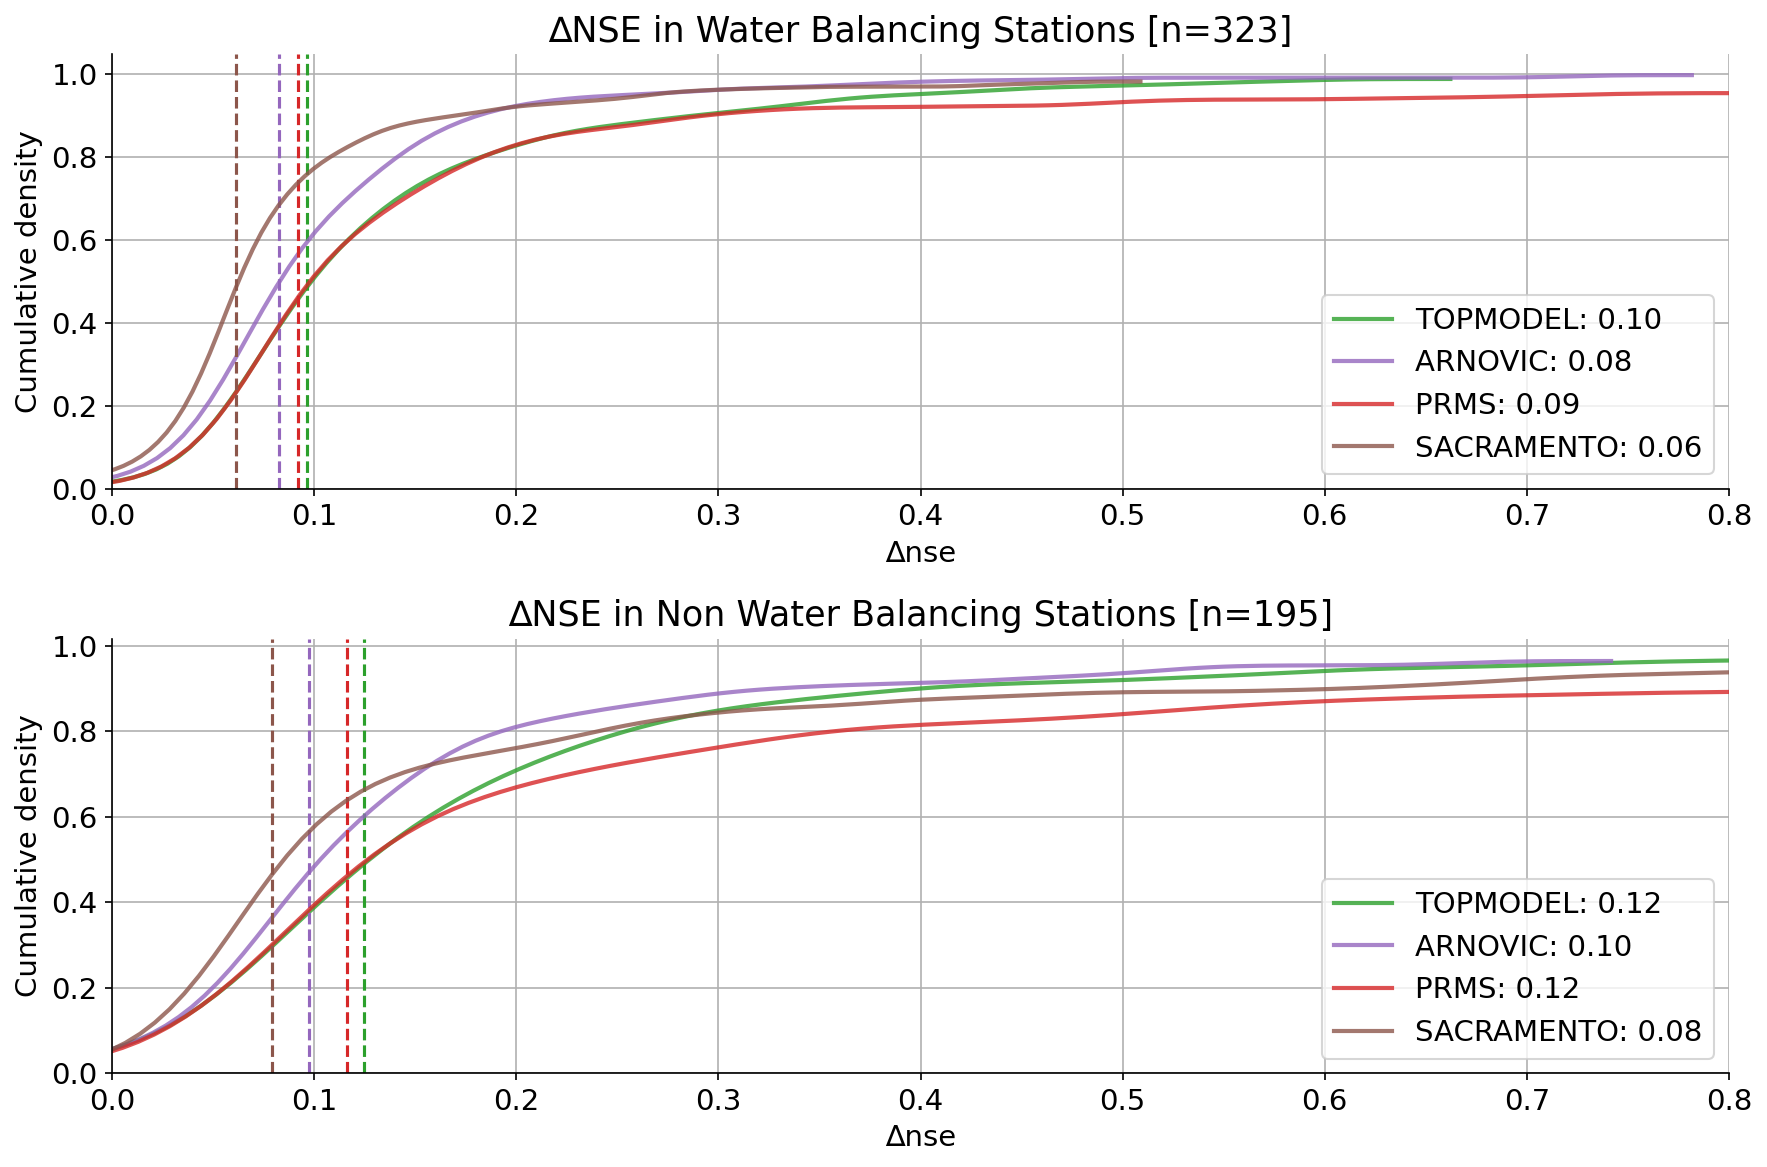

In [92]:
models = ["TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]

f, axs = plt.subplots(2, 1, figsize=((12, 4*2)))
ax = axs[0]
plot_cdf(delta_gdf.loc[np.isin(delta_gdf["ID"], wb_stations.values)], metric="∆nse", models=models, clip=(0, 0.8), ax=ax)
ax.set_title("∆NSE in Water Balancing Stations [n=323]")
ax.grid()

ax = axs[1]
plot_cdf(delta_gdf.loc[~np.isin(delta_gdf["ID"], wb_stations.values)], metric="∆nse", models=models, clip=(0, 0.8), ax=ax)
ax.set_title("∆NSE in Non Water Balancing Stations [n=195]")
ax.grid()

plt.tight_layout()

In [94]:
# delta_gdf.loc[np.isin(delta_gdf["ID"], wb_stations.values), "TOPMODEL"]
# delta_gdf.loc[(~np.isin(delta_gdf["ID"], wb_stations.values)), "TOPMODEL"]

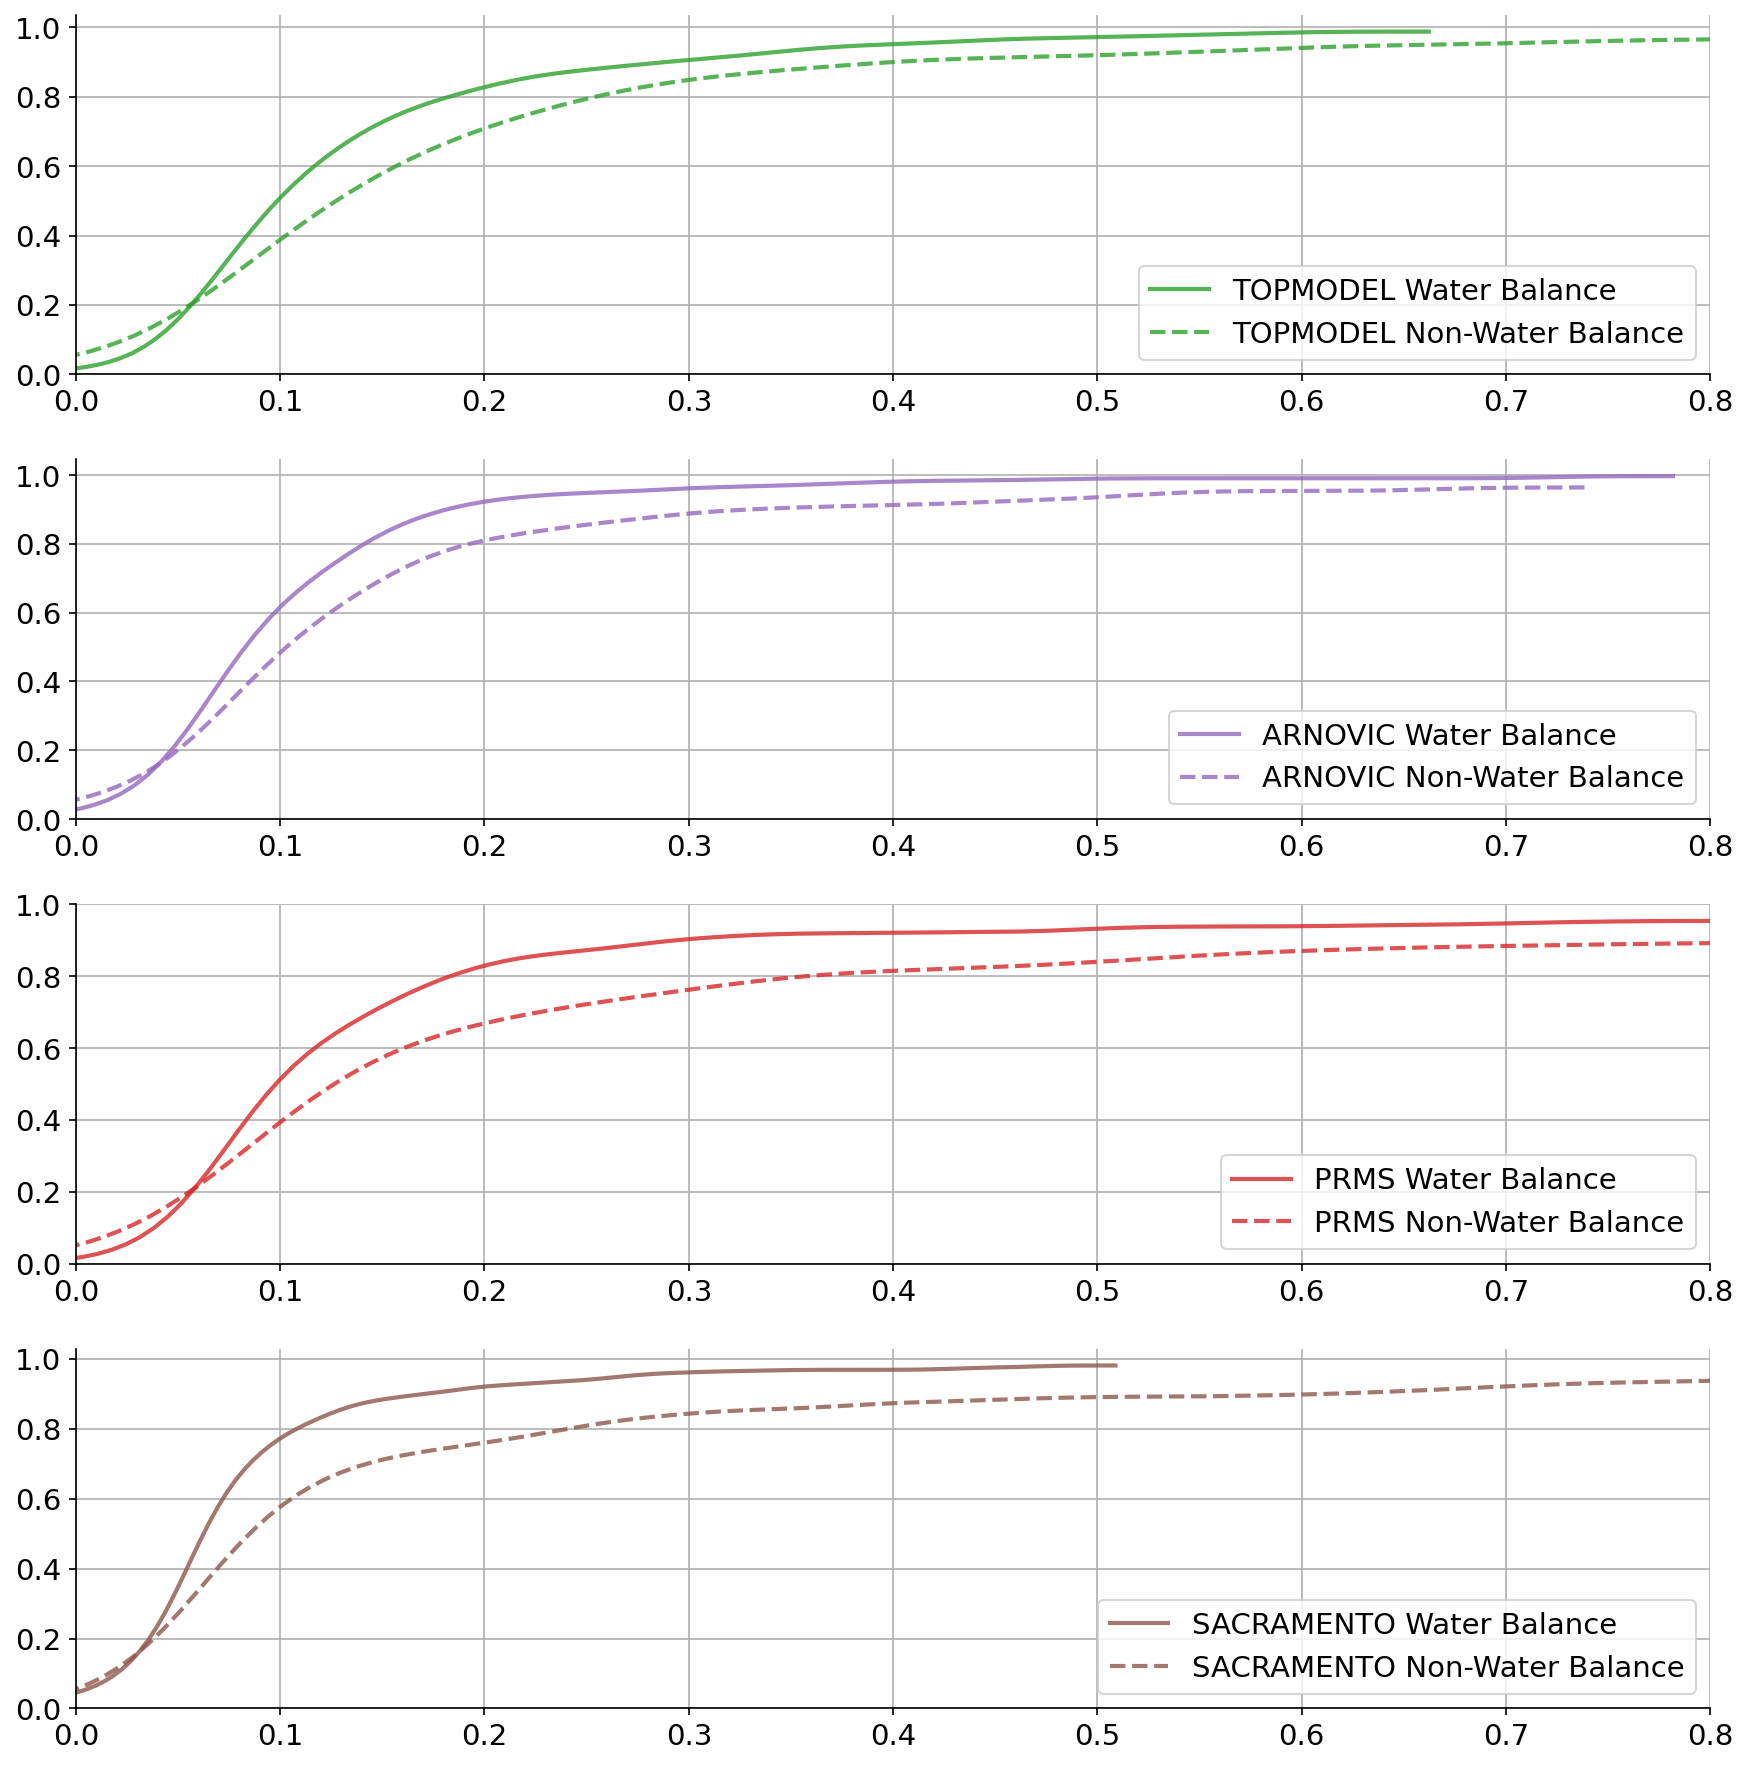

In [95]:
clip=(0, 0.8)
colors = sns.color_palette()
linewidth = 2
wb_kwargs = {
    "TOPMODEL": {"linewidth": linewidth, "alpha": 0.8, "color": colors[2], "clip": clip},
    "PRMS": {"linewidth": linewidth, "alpha": 0.8, "color": colors[3], "clip": clip},
    "ARNOVIC": {"linewidth": linewidth, "alpha": 0.8, "color": colors[4], "clip": clip},
    "VIC": {"linewidth": linewidth, "alpha": 0.8, "color": colors[4], "clip": clip},
    "SACRAMENTO": {"linewidth": linewidth, "alpha": 0.8, "color": colors[5], "clip": clip},
}
nonwb_kwargs = {
    "TOPMODEL": {"linewidth": linewidth, "alpha": 0.8, "color": colors[2], "clip": clip, "ls": "--"},
    "PRMS": {"linewidth": linewidth, "alpha": 0.8, "color": colors[3], "clip": clip, "ls": "--"},
    "ARNOVIC": {"linewidth": linewidth, "alpha": 0.8, "color": colors[4], "clip": clip, "ls": "--"},
    "VIC": {"linewidth": linewidth, "alpha": 0.8, "color": colors[4], "clip": clip, "ls": "--"},
    "SACRAMENTO": {"linewidth": linewidth, "alpha": 0.8, "color": colors[5], "clip": clip, "ls": "--"},
}



f, axs = plt.subplots(len(models), 1, figsize=((12, 3 * len(models))))
for ix, model in enumerate(models):
    ax = axs[ix]
    _wb_data = delta_gdf.loc[np.isin(delta_gdf["ID"], wb_stations.values), model]
    _non_wb_data = delta_gdf.loc[~np.isin(delta_gdf["ID"], wb_stations.values), model]
    _cdf_plot(data=_wb_data, label=f"{model} Water Balance", ax=ax, **wb_kwargs[model])
    _cdf_plot(data=_non_wb_data, label=f"{model} Non-Water Balance", ax=ax, **nonwb_kwargs[model])
    ax.set_xlim(clip)
    ax.legend()
    ax.grid()
    sns.despine()
plt.tight_layout()

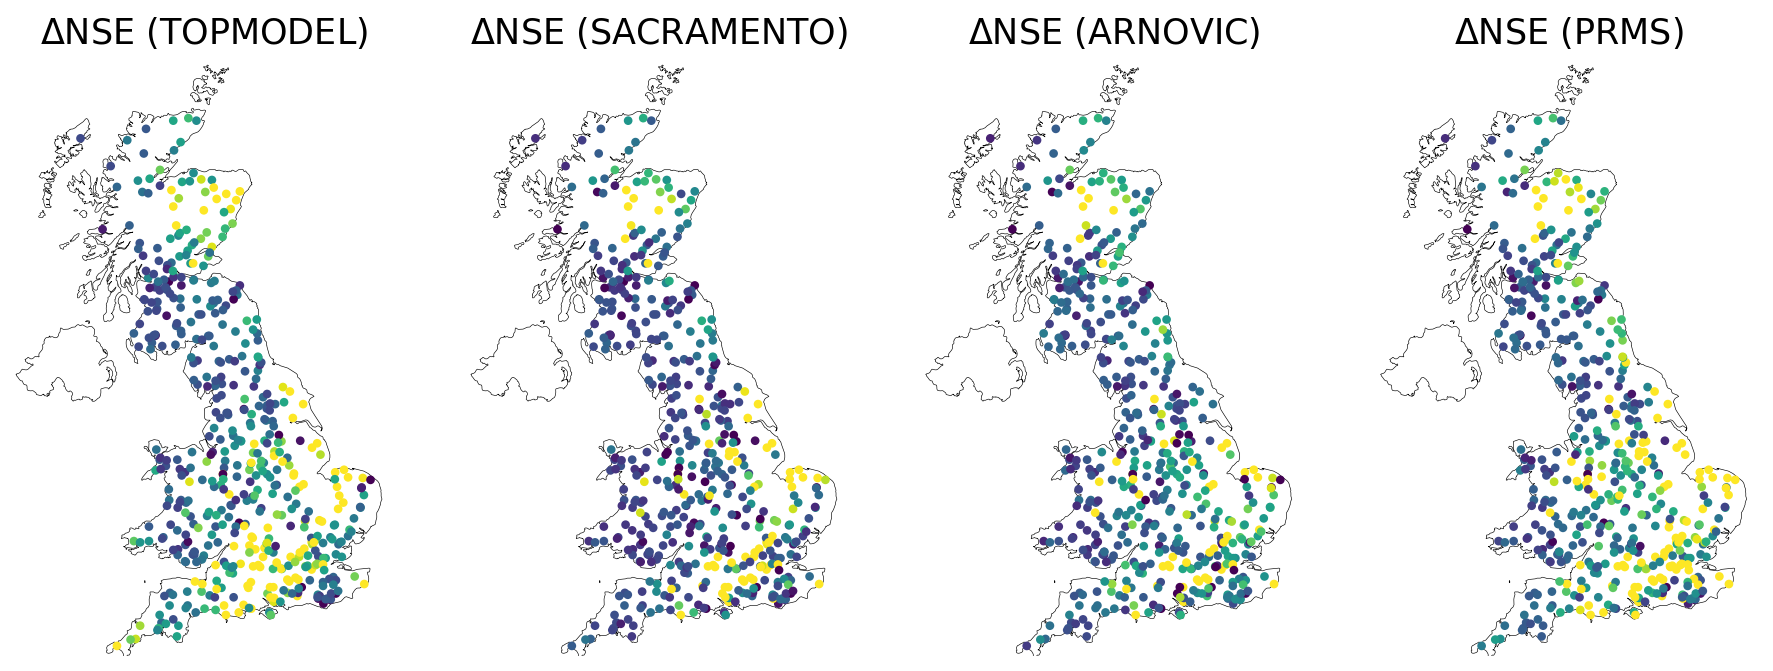

In [96]:
WATER_BALANCE_ONLY = False

markersize = 10
kwargs = {"vmin": 0, "vmax": 0.25, "cmap": "viridis", "markersize": markersize}
models = ["TOPMODEL", "SACRAMENTO", "ARNOVIC", "PRMS"]

from mpl_toolkits.axes_grid1 import make_axes_locatable
f, axs = plt.subplots(1, 4, figsize=(15, 6*4))


for model, ax in zip(models, axs):
#     delta_gdf.plot(model, ax=ax, **kwargs)
    ax.set_title(f"$\Delta$NSE ({model})")
    # plot the surrounding lines
    uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)
    # plot the chloropleth
    if WATER_BALANCE_ONLY:
        delta_gdf.loc[np.isin(delta_gdf["ID"], wb_stations.values)].plot(model, ax=ax, **kwargs);
    else:
        delta_gdf.plot(model, ax=ax, **kwargs);
    ax.set_xlim([-8.2, 2.1])
    ax.set_ylim([50, 59.5])


# divider = make_axes_locatable(axs[3])
# cax = divider.append_axes("right", size="5%", pad=0.1)
# uk.plot(facecolor='none', edgecolor='k', ax=axs[3], linewidth=0.3)
# delta_gdf.plot("PRMS", ax=axs[3], legend=True, cax=cax, **kwargs)

for ax in axs:
    ax.axis('off')

(50.0, 59.5)

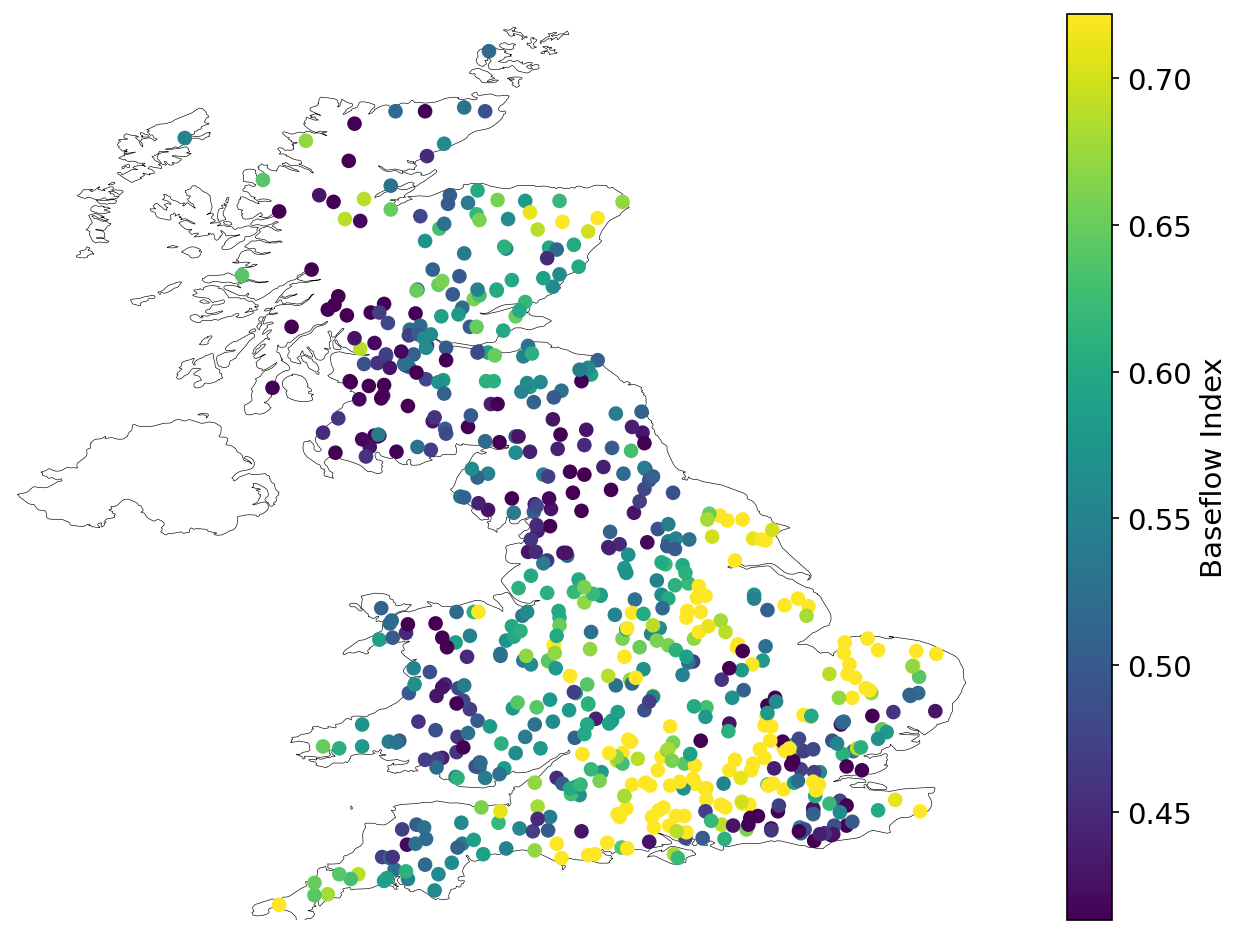

In [99]:
def make_point_static_gdf(feature: str) -> gpd.GeoDataFrame:
    gdf = geo_df.set_index("ID").join(static[feature].to_dataframe()).to_crs(epsg=4326)
    gdf = gpd.GeoDataFrame(gdf.drop("geometry", axis=1).join(points))
    return gdf




variable = "baseflow_index"
vrange = (None, None)

g = make_point_static_gdf(variable)
vrange = (
    np.max([0, g[variable].describe()["25%"] - (g[variable].describe()["std"] * 0.5)]),
    g[variable].describe()["75%"] + (g[variable].describe()["std"] * 0.5)
)
label = "Baseflow Index"
# label = "$\Delta$NSE"


f, ax = plt.subplots(figsize=(12, 8))
# gplt.polyplot(uk, ax=ax)
uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)
g.plot(variable, ax=ax, vmin=vrange[0], vmax=vrange[1], cmap="viridis", legend=True, legend_kwds={"label": label})
# delta_gdf.plot(model, ax=ax, legend=True, legend_kwds={"label": label}, **kwargs);
ax.axis('off');
ax.set_xlim([-8.2, 2.1])
ax.set_ylim([50, 59.5])


In [ ]:
import geoplot as gplt
import matplotlib
# https://github.com/ResidentMario/geoplot/blob/bdffcd6763b8c948ce4d0308855a4df7ef9b7f1e/geoplot/geoplot.py#L467
# https://residentmario.github.io/geoplot/plot_references/plot_reference.html
# Note: can't get the legend for this data

f, axs = plt.subplots(1, 4, figsize=(15, 6*4))

for model, ax in zip(models, axs):
#     delta_gdf.plot(model, ax=ax, **kwargs)
    ax.set_title(f"$\Delta$NSE ({model})")
    
    gplt.polyplot(uk, ax=ax)
#     delta_gdf.plot(model, ax=ax, vmin=0, vmax=0.15)
    cmap = matplotlib.cm.get_cmap('viridis')
    gplt.kdeplot(
        delta_gdf[[model, "geometry"]], 
        cmap=cmap, 
        shade=True, 
        shade_lowest=False, clip=uk, ax=ax, 
#         **{"vmin": 0, "vmax": 0.05}
    )
    ax.set_xlim([-8.2, 2.1])
    ax.set_ylim([50, 59.5])


In [ ]:
def make_point_static_gdf(feature: str) -> gpd.GeoDataFrame:
    gdf = geo_df.set_index("ID").join(static[feature].to_dataframe()).to_crs(epsg=4326)
    gdf = gpd.GeoDataFrame(gdf.drop("geometry", axis=1).join(points))
    return gdf



In [ ]:
# # geo_df
# q_mean = geo_df.set_index("ID").join(static["q_mean"].to_dataframe()).to_crs(epsg=4326)
# q_mean = gpd.GeoDataFrame(q_mean.drop("geometry", axis=1).join(points))
q_mean = make_point_static_gdf("q_mean")

# # q_mean.crs = {'init' :'epsg:4326'}

# f, ax = plt.subplots()
# cmap = matplotlib.cm.get_cmap('plasma')
# gplt.polyplot(uk, ax=ax)
# gplt.kdeplot(
#     q_mean[["q_mean", "geometry"]], 
#     cmap=cmap, 
#     shade=True, 
#     shade_lowest=True, clip=uk, ax=ax, 
#     **{"vmin": None, "vmax": 2.640000}
# )
# # ax.set_xlim([-8.2, 2.1])
# # ax.set_ylim([50, 59.5])

In [ ]:
variable = "q_mean"
vrange = (None, None)

g = make_point_static_gdf(variable)
vrange = (
    np.max([0, g[variable].describe()["25%"] - (g[variable].describe()["std"] * 0.5)]),
    g[variable].describe()["75%"] + (g[variable].describe()["std"] * 0.5)
)
label = variable + " [mm day$^{-1}$]"


f, ax = plt.subplots(figsize=(12, 8))
# gplt.polyplot(uk, ax=ax)
uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)
g.plot(variable, ax=ax, vmin=vrange[0], vmax=vrange[1], cmap="viridis", legend=True, legend_kwds={"label": label})
ax.axis('off');
ax.set_xlim([-8.2, 2.1])
ax.set_ylim([50, 59.5])


In [ ]:
# variable = "low_prec_freq"

# g = make_point_static_gdf(variable)
# vrange = (None, None)
# vrange = (
#     np.max([0, g[variable].describe()["25%"] - (g[variable].describe()["std"] * 0.5)]),
#     g[variable].describe()["75%"] + (g[variable].describe()["std"] * 0.5)
# )
# label = variable + " [mm day$^{-1}$]"

# f, ax = plt.subplots(figsize=(12, 8))
# # gplt.polyplot(uk, ax=ax)
# uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)
# g.plot(variable, ax=ax, vmin=vrange[0], vmax=vrange[1], cmap="viridis", legend=True, legend_kwds={"label": label})
# ax.axis('off');
# ax.set_xlim([-8.2, 2.1])
# ax.set_ylim([50, 59.5])

In [ ]:
# variable = "low_prec_freq"

# g = make_point_static_gdf(variable)
# vrange = (None, None)
# vrange = (
#     np.max([0, g[variable].describe()["25%"] - (g[variable].describe()["std"] * 0.5)]),
#     g[variable].describe()["75%"] + (g[variable].describe()["std"] * 0.5)
# )
# label = variable + " [mm day$^{-1}$]"

# f, ax = plt.subplots(figsize=(12, 8))
# # gplt.polyplot(uk, ax=ax)
# uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)
# g.plot(variable, ax=ax, vmin=vrange[0], vmax=vrange[1], cmap="viridis", legend=True, legend_kwds={"label": label})
# ax.axis('off');

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_static_feature_map(feature: str, label: str = None, ax = None, cmap: str = "viridis"):
    if ax is None:
        f, ax = plt.subplots()
    else:
        f = plt.gcf()
    g = make_point_static_gdf(feature)

    vrange = (
        np.max([0, g[feature].describe()["25%"] - (g[feature].describe()["std"] * 0.5)]),
        g[feature].describe()["75%"] + (g[feature].describe()["std"] * 0.5)
    )
    
    uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
    f.add_axes(cax)

    g.plot(feature, ax=ax, vmin=vrange[0], vmax=vrange[1], cmap=cmap, legend=True, cax=cax, legend_kwds={"label": label, "orientation": "horizontal"})
    ax.axis('off');
    ax.set_xlim([-8.2, 2.1])
    ax.set_ylim([50, 59.5])

    return ax

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

feature = "q_mean"
label = " Mean Discharge (Q) [mm day$^{-1}$]"
plot_static_feature_map(feature=feature, label=label, ax=axs[0])

feature = "Q5"
label = feature + " [mm day$^{-1}$]"
plot_static_feature_map(feature=feature, label=label, ax=axs[1])

feature = "low_prec_freq"
label = "Frequency of dry days (< 1 mm d$^{-1}$1) [d yr$^{-1}$]"
plot_static_feature_map(feature=feature, label=label, ax=axs[2], cmap="Reds")

# Explore Delta NSE

# What patterns in delta nse

# Spearmans Rank Correlation between static features & DeltaNSE

In [ ]:
from scipy.stats import spearmanr
from collections import defaultdict

In [ ]:
delta_nse = lstm_delta_nse
stations = [sid for sid in delta_nse["TOPMODEL"].dropna().index]
models = ["TOPMODEL", "PRMS", "SACRAMENTO", "ARNOVIC"]

# numerical non nan rows
static_ = static_df.loc[stations, (static_df.dtypes == "float64")]
static_ = static_df.loc[:, ~(static_df.isnull().mean(axis=0) > 0)]

all_spearmans = {}
for model in models:
    spearmans_rank = defaultdict(dict)
    for static_feature in static_.columns:
        a = static_df.loc[stations, static_feature]
        b = delta_nse.loc[stations, model]
        assert a.isnull().mean() == 0, f"{static_feature}"

        res = spearmanr(a, b)
        spearmans_rank[static_feature]["correlation"] = res.correlation
        spearmans_rank[static_feature]["pvalue"] = res.pvalue

    spear_df = pd.DataFrame(spearmans_rank).T.reset_index().rename({"index": "feature"}, axis=1)
    all_spearmans[model] = spear_df

In [ ]:
from typing import List


def get_intersection_of_significant_features(all_spearmans: Dict[str, pd.DataFrame],p=0.01) -> List[str]:
    # get the features that have a significant correlation (p<0.01)
    all_features = []
    
    models = ["TOPMODEL", "PRMS", "SACRAMENTO", "ARNOVIC"]
    for ix, model in enumerate(models):
        sign_df = all_spearmans[model].loc[all_spearmans[model]["pvalue"] < p]
        all_features.append(sign_df["feature"].to_list())

    intersecting_features = set.intersection(*[set(feat) for feat in all_features])
    return list(intersecting_features)

intersecting_features = get_intersection_of_significant_features(all_spearmans, 0.01)

In [ ]:
def create_long_form_dataset(all_spearmans: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    # create long form dataset
    all_correlations = []
    models = [k for k in all_spearmans.keys()]
    for ix, model in enumerate(models):
        df = all_spearmans[model]
        df["model"] = [model for _ in range(len(df))]
        all_correlations.append(df)

    all_correlations = pd.concat(all_correlations)
    return all_correlations

all_correlations = create_long_form_dataset(all_spearmans)

In [ ]:
n_largest = 10
# def plot_the_10_significant_highest_correlations(all_spearmans: Dict[str, pd.DataFrame], p_value: float = 0.01, n_largest:int = 10):
# 1. get intersection of features for all models that have p<p_value
intersecting_features = get_intersection_of_significant_features(all_spearmans, 0.01)
# 2. create long form dataframe
all_correlations = create_long_form_dataset(all_spearmans)
# 3. subset the features that are significant for all models
all_correlations = all_correlations.loc[np.isin(all_correlations["feature"], intersecting_features)]
# drop the matching baseflow index
all_correlations = all_correlations[~np.isin(all_correlations["feature"], ["baseflow_index_ceh", ""])]
# 4. subset the n features with the largest mean correlation (across the 4 models)
n_largest_features = all_correlations.groupby("feature").median()["correlation"].abs().nlargest(n_largest).index
all_correlations = all_correlations.loc[np.isin(all_correlations["feature"], n_largest_features)]
all_correlations = all_correlations.sort_values(["correlation"])
# 5. subset the n largest features
all_correlations

fig, ax = plt.subplots()
sns.barplot(x="feature", y="correlation", data=all_correlations, ax=ax, color="grey")   # hue="model", 
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_title(f"Top {n_largest} features: Abs(Correlation($\Delta$NSE, Feature))")
ax.set_ylabel("$\\rho$($\Delta$NSE, feature)")
sns.despine()

In [ ]:
# plot correlation for top n features for each model (split by model delta nse)
if False:
    f, axs = plt.subplots(4, 1, figsize=(12, 4*4))
    plot_all = False
    nlargest = 10

    for ix, model in enumerate(models):
        ax = axs[ix]
        if plot_all:
            # only select those with p values below X point
            sign_df = all_spearmans[model].loc[all_spearmans[model]["pvalue"] < 0.01]
            sign_df.sort_values("correlation").set_index("feature")["correlation"].plot.bar(ax=ax)
        else:
            # Plot Intersecting features
            intersect_df = all_spearmans[model].set_index("feature").loc[list(intersecting_features)]
            n_largest_features = intersect_df["correlation"].abs().nlargest(nlargest).index
            sort_df = intersect_df.loc[n_largest_features].sort_values("correlation")["correlation"]
            sort_df.plot.bar(ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
        ax.set_title("Correlation($Delta$NSE$_{" + model + "}$, Static Features)")
        ax.set_ylabel("$\\rho$")
        sns.despine()

    plt.tight_layout()

In [ ]:
# sign_df.set_index("feature")["correlation"]

In [ ]:
# all_spearmans["TOPMODEL"]["feature"]

In [ ]:
sign_features = {}
for model in models:
    # only select those with p values below X point
    sign_df = all_spearmans[model].loc[all_spearmans[model]["pvalue"] < 0.01]
    sign_features[model] = sign_df["feature"].values

# features across all four models
sets = [set(v) for v in sign_features.values()]
features_for_analysis = list(sets[0].intersection(sets[1]).intersection(sets[2]).intersection(sets[3]))
features_for_analysis
len(features_for_analysis)

### Other correlation plots

In [ ]:
# plot ordered plot of correlation of features for EACH model and ALL significant  features
if False:
    for model in models:
        # only select those with p values below X point
        sign_df = all_spearmans[model].loc[all_spearmans[model]["pvalue"] < 0.01]

        f, ax = plt.subplots(figsize=(12, 4))
        # spear_df.reindex(spear_df["correlation"].abs().sort_values(ascending=False).index)
        sign_df.sort_values("correlation").set_index("feature")["correlation"].plot.bar(ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
        ax.set_title("Correlation($Delta$NSE$_{" + model + "}$, Static Features)")
        ax.set_ylabel("$\\rho$")
        sns.despine()

In [ ]:
#  Plot the normalised values of NSE vs. static feature - regression plots
if False:
    from sklearn.preprocessing import normalize, MinMaxScaler
    stations = [sid for sid in delta_nse["TOPMODEL"].dropna().index]

    norm_static = pd.DataFrame(MinMaxScaler().fit_transform(static))
    norm_static.columns = static.columns
    norm_static.index = static.index

    delta_nse_nonans = delta_nse.dropna()
    norm_nse = pd.DataFrame(MinMaxScaler().fit_transform(delta_nse_nonans))
    norm_nse.columns = delta_nse_nonans.columns
    norm_nse.index = delta_nse_nonans.index

    n_rows = (len(features_for_analysis) // 2) + (len(features_for_analysis) % 2)
    f, axs = plt.subplots(n_rows, 2, figsize=(3*2, 2*n_rows))
    for ix, static_feature in enumerate(features_for_analysis):
        ax_ix = np.unravel_index(ix, (n_rows, 2))
        ax = axs[ax_ix]

        # get the X, y data
        sort_index = norm_nse.loc[stations, model].sort_values(ascending=True).index
        y = norm_static.loc[stations, static_feature].reindex(sort_index)
        x = norm_nse.loc[stations, model].reindex(sort_index)
        ax.scatter(x, y)

        # plot regression
        coef = np.polyfit(x, y, 1)
        poly1d_fn = np.poly1d(coef) 
        y_hat = poly1d_fn(x)
        ax.plot(x, y_hat, ls=":", color="k", label=f"{coef[0]:.2f}")

        ax.set_title(static_feature)
        ax.legend()

        if ax_ix[0] == n_rows - 1:
            ax.set_xlabel("$\Delta$NSE")
        sns.despine()

    plt.tight_layout()

# Where does the LSTM do worse?

In [ ]:
from matplotlib import colors

cmap = colors.ListedColormap(["grey", sns.color_palette()[0]])

f, axs = plt.subplots(1, 4, figsize=(12, 8*4))

worse_basins = {}
for ix, model in enumerate(models):
    ax = axs[ix]
    ax.set_title(model)
    delta_gdf[f"{model}_bool"] = delta_gdf[model] < 0
    # delta_gdf.plot(f"{model}_bool", ax=ax, cmap=cmap, markersize=10)
    delta_gdf.loc[delta_gdf[model] > 0].plot(f"{model}_bool", ax=ax, color="grey", markersize=10)
    delta_gdf.loc[delta_gdf[model] < 0].plot(f"{model}_bool", ax=ax, color="blue", markersize=None)
    
    worse_basins[model] = delta_gdf.loc[delta_gdf[model] < 0].index
    
for ax in axs:
    ax.axis('off')

In [ ]:
flatten = lambda t: [item for sublist in t for item in sublist]

all_worse_sids = set(flatten(worse_basins.values()))

In [ ]:
print(f"{len(all_worse_sids)} Catchments that LSTMs Worse (than ANY conceptual)")

In [ ]:
# def smooth_lowess(x, y, kwargs: Dict = {}) -> Tuple[pd.Series]:
#     from statsmodels.nonparametric.smoothers_lowess import lowess

#     # wrapper for statsmodels lowess
#     try:
#         smooth_y = lowess(y, x, return_sorted=False, **kwargs)
#     except AttributeError:
#         x, y = x.values.flatten(), y.values.flatten()
#         smooth_y = lowess(y, x, return_sorted=False, **kwargs)
    
#     df = x.rename("x").to_frame()
#     df["y"] = smooth_y
#     df = df.dropna().sort_values("x")
#     return df["x"], df["y"]

# import patsy
# patsy.dmatrix("")

def lr_line(x: pd.Series, y: pd.Series) -> np.array:
    x_unique = np.unique(x)
    
    # fit the coefficients
    reg = np.polyfit(x, y, 1)
    # make a prediction
    lm = np.poly1d(reg)
    y_hat = lm(x_unique)

    return x_unique, y_hat

In [ ]:
xvar = "baseflow_index"
yvar = "q_mean"
yvar = "Q95"
spline = True

# f, axs = plt.subplots(1, 2)

# ax = axs[0]

f, ax = plt.subplots()
x = static[xvar].to_dataframe()
y = static[yvar].to_dataframe()

ax.scatter(x, y, alpha=0.7)
# x_uq, y_hat = lr_line(x[xvar], y[yvar])
# ax.plot(x_uq, y_hat, color="k", ls="--")

ax.set_xlabel(xvar)
ax.set_ylabel(yvar)

sns.despine()

In [ ]:
import patsy
x_1d = x[xvar]
y_1d = y[yvar]
X = patsy.dmatrix("bs(x_1d, df=6, degree=3, include_intercept=True) - 1")
from sklearn import linear_model
clf = linear_model.LinearRegression()

clf.fit(X, y_1d)
yhat = clf.predict(X)

X

In [ ]:
print(dir(X))

## Which basins do all 3 of the conceptual models outperform the LSTM

In [ ]:
conceptual_better = delta_gdf[[c for c in delta_gdf.columns if "bool" in c]]
# conceptual_better[np.any(conceptual_better, axis=1)]
worse_stations = [sid for sid in conceptual_better[np.all(conceptual_better, axis=1)].index if sid in matching_stations]
len(conceptual_better[np.all(conceptual_better, axis=1)])
worse_stations
len(worse_stations)

In [ ]:
def plot_stations(stations):
    f, ax = plt.subplots() 

    delta_gdf.loc[~np.isin(delta_gdf.index, stations)].plot(f"{model}_bool", ax=ax, color="grey", markersize=10)
    delta_gdf.loc[np.isin(delta_gdf.index, stations)].plot(f"{model}_bool", ax=ax, color="blue", markersize=None)
    ax.axis('off')

In [ ]:
f, ax = plt.subplots() 

delta_gdf.loc[~np.isin(delta_gdf.index, worse_stations)].plot(f"{model}_bool", ax=ax, color="grey", markersize=10)
delta_gdf.loc[np.isin(delta_gdf.index, worse_stations)].plot(f"{model}_bool", ax=ax, color="blue", markersize=None)
ax.axis('off')

In [ ]:
fuse_errors_fp = data_dir / "RUNOFF/0_fuse_errors.pkl"
fuse_class_fp = data_dir / "RUNOFF/0_fuse_class.pkl"

f_class = pickle.load(fuse_class_fp.open("rb"))
fuse_errors = pickle.load(fuse_errors_fp.open("rb"))
vic_error = f_class.get_model_df("VIC")
prms_error = f_class.get_model_df("PRMS")
top_error = f_class.get_model_df("TOPMODEL")
sac_error = f_class.get_model_df("Sacramento")

In [ ]:
# worse_df
order_ = nse_df.loc[[int(sid) for sid in all_worse_sids]].drop("Name", axis=1)
order_ = (order_["LSTM"] - order_.drop("LSTM", axis=1).T).min().sort_values()

print(f"Median Absolute Delta NSE for the Stations where DeltaNSE < 0: {order_.abs().median():.02f}")
print(order_.index)

In [ ]:
worse_nse = nse_df.loc[[int(sid) for sid in all_worse_sids]]
len(worse_nse)
worse_nse.index

In [ ]:
# lstm_metric_df
worse_nse = nse_df.loc[[int(sid) for sid in all_worse_sids]]

worse_df = worse_nse.reset_index().set_index(["index", "Name"]).stack().reset_index(-1).rename({"level_2": "model", 0: "nse"}, axis=1).reset_index("Name")
worse_df = worse_df.reset_index().rename({"index": "station_id"}, axis=1).astype({"station_id": str})

# order from greatest difference to minimum difference
worse_df = worse_df.set_index("station_id").loc[[str(sid) for sid in order_.index]]

# len(worse_df)
worse_df

## Plot the RAW NSEs for the comparison models

In [ ]:
scale = 1.1

# plot_data = worse_df 
# plot_data["nse"] = plot_data["nse"] + np.random.normal(0, 0.01, len(plot_data["nse"]))
# TOPMODEL (green), VIC (red), PRMS (purple), Sacramento
model_order = ["LSTM", "EALSTM", "TOPMODEL", "VIC", "PRMS", "Sacramento"]
abs_ = True
f, ax = plt.subplots(figsize=(12*scale, 4*scale))

colors = sns.color_palette()[1: len(model_order)]
for ix, model in enumerate(model_order[1:]):
    plot_data = worse_df.loc[worse_df["model"] == model]
    ax.scatter(plot_data["Name"], plot_data["nse"], color=colors[ix], s=60, label=model)

plot_data = worse_df.loc[worse_df["model"] == "LSTM"]
ax.scatter(plot_data["Name"], plot_data["nse"], color="k", marker="x", s=100, label="LSTM")

# sns.scatterplot(x="Name", y="nse", hue="model", data=worse_df, hue_order=model_order, )
# ax.set_xticklabels(rotation = 45, ha="right")
plt.xticks(rotation=45, ha="right")

ax.set_xlabel("Station")
ax.set_ylabel("NSE")
ax.set_ylim(0, 1)
ax.legend()

# Plot the raw difference
ax2 = ax.twinx()
if abs_:
    ax2.bar(plot_data["Name"], abs(order_), alpha=0.3)
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("Absolute $\Delta$NSE")
else:
    ax2.bar(plot_data["Name"], order_, alpha=0.3)
    ax2.set_ylim(-0.7, 0)
    ax2.set_ylabel("$\Delta$NSE")
# sns.despine()

In [ ]:
plot_data["Name"].index

In [ ]:
static = all_static
station_names = static["gauge_name"].to_dataframe()

worse_stations_ = worse_stations
# ANY worse basins = 33
# worse_stations = [int(sid) for sid in all_worse_sids]
# ALL worse basins = 3
# worse_stations = [int(sid) for sid in worse_stations_]

f, axs = plt.subplots(len(worse_stations), 1, figsize=(6, 3*len(worse_stations)))
for ix, sid in enumerate(lstm_preds.sel(station_id=worse_stations).station_id):
    ax = axs[ix]
    # LSTM
    lstm_preds.sel(station_id=sid, time=lstm_preds["time.year"] == 2007)["sim"].plot(ax=ax, **{"label": "LSTM", "linewidth": 1})

    # conceptual models
    fuse_d = fuse_ds.sel(station_id=sid, time=fuse_ds["time.year"] == 2007)
    for v in [str(v) for v in fuse_d.data_vars]:
        fuse_d[v].plot(ax=ax, **{"label": str(v).replace("SimQ_", ""), "linewidth": 1})
    
    # obs
    lstm_preds.sel(station_id=sid, time=lstm_preds["time.year"] == 2007)["obs"].plot(ax=ax, color="k", ls=":", **{"label": "Observation"})
    
    # title
    name = str(station_names.loc[int(sid)][0])
    nse = float(lstm_metric_df.loc[int(sid), "nse"])
    top_nse = top_error.loc[int(sid)]["nse"]
    vic_nse = vic_error.loc[int(sid)]["nse"]
    prm_nse = prms_error.loc[int(sid)]["nse"]
    sac_nse = sac_error.loc[int(sid)]["nse"]
    ax.set_title(
        f"{name}\n"
        f"LSTM: {nse:.2f} -- TOP: {top_nse:.2f} -- Sac: {sac_nse:.2f} -- PRMS: {prm_nse:.2f} -- VIC: {vic_nse:.2f}"
    )
    if ix == 0:
        ax.legend()

plt.tight_layout()
sns.despine()

worse_stations = worse_stations_

## Measure the difference between Catchments - KS Test 
- [Scipy implementation](https://stats.stackexchange.com/questions/354035/how-to-compare-the-data-distribution-of-2-datasets)
- This is a two-sided test for the null hypothesis that 2 independent samples are drawn from the same continuous distribution. The alternative hypothesis can be either ‘two-sided’ (default), ‘less’ or ‘greater’.
- If the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same


In [ ]:
from scipy.stats import ks_2samp
from collections import defaultdict

In [ ]:
# (static_df.dtypes == "float64").sum()
better_stations = np.isin(static_df.index, conceptual_better.any(axis=1).index[conceptual_better.any(axis=1)])

In [ ]:
wilcoxon_results = defaultdict(dict)
for static_feature in static_df.loc[:, static_df.dtypes == "float64"].columns:
    test_result = ks_2samp(
        static_df.loc[better_stations, static_feature],
        static_df.loc[[ix for ix in static_df.index if ix not in better_stations], static_feature]
    )
    wilcoxon_results[static_feature]["statistic"] = test_result.statistic
    wilcoxon_results[static_feature]["pvalue"] = test_result.pvalue
    
ks_df = pd.DataFrame(wilcoxon_results).T.reset_index().rename({"index": "static_feature"}, axis=1)
ks_df.sort_values("pvalue").head(20)

In [ ]:
static_for_worse = static_df.loc[better_stations, ks_df.loc[ks_df["pvalue"] < 0.05, "static_feature"]]
static_for_better = static_df.loc[[ix for ix in static_df.index if ix not in better_stations], ks_df.loc[ks_df["pvalue"] < 0.05, "static_feature"]]
display(static_for_better.head())
display(static_for_worse.head())

# Plot ECDFs for features with significant difference
1. Get the basins where ANY of the conceptual models outperform the LSTM models
1. calculate the KS statistic for all of the continuous static features 
1. Select the static features that KS statistic is p < 0.05
1. Plot those as ECDFs

In [ ]:
def ecdf(x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Calculate empirical cummulative density function

    Parameters
    ----------
    x : np.ndarray
        Array containing the data

    Returns
    -------
    x : np.ndarray
        Array containing the sorted metric values
    y : np.ndarray]
        Array containing the sorted cdf values
    """
    xs = np.sort(x)
    ys = np.arange(1, len(xs) + 1) / float(len(xs))
    return xs, ys

In [ ]:
f, axs = plt.subplots(16, 4, figsize=(3*4, 1*16))

static_feature = "frac_high_perc"

for ix, static_feature in enumerate(static_for_better.columns):
    ax = axs[np.unravel_index(ix, (16, 4))]
    # sns.kdeplot(static_for_better.loc[:, static_feature].dropna(), ax=ax, label="Better", shade=False, cumulative=True, legend=False if ix != 0 else True)
    # sns.kdeplot(static_for_worse.loc[:, static_feature].dropna(), ax=ax, label="Worse", shade=False, cumulative=True, legend=False if ix != 0 else True)
    ax.plot(*ecdf(static_for_better.loc[:, static_feature].dropna()), label="Better")
    ax.plot(*ecdf(static_for_worse.loc[:, static_feature].dropna()), label="Worse")

    ax.set_title(static_feature)
    ax.axis("off")
    
plt.tight_layout()


# Central Belt of Scotland

In [ ]:
# import folium
g = make_point_static_gdf("baseflow_index")
gjson = g.to_json()

In [ ]:
def plot_stations(stations):
    f, ax = plt.subplots() 
    isin_stations = delta_gdf.loc[np.isin(delta_gdf.index, stations)].index
    
    delta_gdf.loc[~np.isin(delta_gdf.index, stations)].plot(f"{model}_bool", ax=ax, color="grey", markersize=10)
    delta_gdf.loc[np.isin(delta_gdf.index, stations)].plot(f"{model}_bool", ax=ax, color="blue", markersize=None)
    ax.axis('off')
    return isin_stations

In [ ]:
stations = np.append(np.arange(84000, 84100), np.arange(83000, 83100))
# stations = 
stations = np.append(np.arange(15000, 18100), np.arange(85000, 85100))
# stations = np.arange(15000, 15100)
# plot_stations(stations=stations)

c_scotland_stations = plot_stations(stations=stations)
print(len(c_scotland_stations))

In [ ]:
KDEPLOT = True
metric = "nse"

f, ax = plt.subplots()
if KDEPLOT:
    sns.kdeplot(metric_df[metric], ax=ax, clip=(0, 1), cumulative=True, label="All of GB")
    sns.kdeplot((metric_df.set_index("station_id").loc[c_scotland_stations, metric]), ax=ax, clip=(0, 1), cumulative=True, label="Scotland")
else:
    sns.distplot(metric_df[metric], ax=ax, label="All of GB")
    sns.distplot((metric_df.set_index("station_id").loc[c_scotland_stations, metric]), ax=ax, label="Scotland")

ax.set_xlim(0, 1)
sns.despine()
ax.set_xlabel(metric)
ax.legend()

In [ ]:
stations = np.concatenate([np.arange(40000, 41100), np.arange(39010, 39020)])
# stations = np.arange(38000, 41100)
# stations = np.arange(41000, 41100)
# stations = np.arange(39010, 39020)
if True:
    se_stations = plot_stations(stations=stations)
    print(len(se_stations))
#     se_stations

In [ ]:
# metric_df
# lstm_error_df
# lstm_metric_df

In [ ]:
(lstm_metric_df.loc[se_stations, "nse"]).median()

In [ ]:
KDEPLOT = False
metric = "bias"

f, ax = plt.subplots()
if KDEPLOT:
    sns.kdeplot(lstm_metric_df[metric], ax=ax, clip=(0, 1) if metric in ["nse", "kge"] else None, cumulative=True, label="All of GB")
    sns.kdeplot((lstm_metric_df.loc[se_stations, metric]), ax=ax, clip=(0, 1) if metric in ["nse", "kge"] else None, cumulative=True, label="SE England")
else:
    sns.distplot(lstm_metric_df[metric], ax=ax, label="All of GB")
    sns.distplot((lstm_metric_df.loc[se_stations, metric]), ax=ax, label="SE England")

if metric in ["nse", "kge"]:
    ax.set_xlim(0, 1)
elif metric == "bias":
    ax.axvline(0, ls="--", alpha=0.5, color="grey")
sns.despine()
ax.set_xlabel(metric)
ax.legend()

In [ ]:
lstm_delta["nse"]

KDEPLOT = True
metric = "nse"
model = "TOPMODEL"
f, ax = plt.subplots()


if KDEPLOT:
    sns.kdeplot(lstm_delta[metric][model], ax=ax, clip=(0, 1) if metric in ["nse", "kge"] else None, cumulative=True, label="All of GB")
    sns.kdeplot((lstm_delta[metric].loc[se_stations, model]), ax=ax, clip=(0, 1) if metric in ["nse", "kge"] else None, cumulative=True, label="SE England")
else:
    sns.distplot(lstm_delta[metric][model], ax=ax, label="All of GB", bins=20, norm_hist=True)
    sns.distplot(lstm_delta[metric].loc[se_stations, model], ax=ax, label="SE England", bins=20, norm_hist=True)

if metric in ["nse", "kge"]:
    if KDEPLOT:
        ax.set_xlim(0, 1)
    else:
        ax.set_xlim(-1, 1)
elif metric == "bias":
    ax.axvline(0, ls="--", alpha=0.5, color="grey")
sns.despine()
ax.set_xlabel("∆" + metric)
ax.legend()

In [ ]:
?sns.distplot

In [ ]:
all_metric_se = []
all_metric = 
metric = "nse"
for model in models:
    all_metric_se.append(lstm_delta[metric].loc[se_stations, model])
    all_metric.append(lstm_delta[metric][model])
    print(f"SE Stations Median {model} ∆{metric}: {lstm_delta[metric].loc[se_stations, model].median():.2f}")
    print(f"ALL Stations Median {model}  ∆{metric}: {lstm_delta[metric][model].median():.2f}")

In [ ]:
print(f"SE Median ∆: {(pd.concat(all_metric_se)).median():.2f}")
print(f"SE Median ∆: {(pd.concat(all_metric)).median():.2f}")

# Bayesian Analysis supersedes the T Test (BEST)
- [BEST Python tool](https://best.readthedocs.io/en/latest/)
- [BEST in PyMC3](https://docs.pymc.io/notebooks/BEST.html)
- [Using R and Stan w/BRMS](https://vuorre.netlify.app/post/2017/01/02/how-to-compare-two-groups-with-robust-bayesian-estimation-using-r-stan-and-brms/)
- [Original Paper](https://jkkweb.sitehost.iu.edu/BEST/BEST.pdf)

# What characteristics where we do better / worse

In [ ]:
# Worse?
worse_cments_top = static_df[(lstm_delta_nse < 0)["TOPMODEL"]]
worse_cments_sac = static_df[(lstm_delta_nse < 0)["Sacramento"]]
worse_cments_vic = static_df[(lstm_delta_nse < 0)["VIC"]]
worse_cments_prms = static_df[(lstm_delta_nse < 0)["PRMS"]]

In [ ]:
# sns.distplot(worse_cments_top["aridity"], label="TOPMODEL")
# sns.distplot(worse_cments_sac["aridity"], label="Sacramento")
# sns.distplot(worse_cments_vic["aridity"], label="VIC")
# sns.distplot(worse_cments_prms["aridity"], label="PRMS")
# plt.legend()
# sns.despine()

### Is delta NSE predictable?
Random forests tuning ([DataScienceMedium](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74))
- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node

[Sklearn Docs - RF Parameters](https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters): 
- main parameters to adjust when using these methods is `n_estimators` and `max_features`

In [ ]:
from rfpimp import (
    importances, 
    plot_importances, 
    plot_corr_heatmap, 
    feature_corr_matrix, 
    feature_dependence_matrix,
    plot_dependence_heatmap
)

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split

"""
    rf = RandomForestRegressor(
        random_state = 42,
        n_estimators=200, # 200 100
        max_features=50,  # 50  10
        max_depth=100,    # 100  5 
        min_samples_split=2, # 2
        min_samples_leaf=1,  # 1
        oob_score=False,   # True
    )
    
    rf = RandomForestRegressor(
        random_state=42, 
        n_estimators=200,
        max_features=100//3,
    )
""";

In [ ]:
targets = lstm_delta["nse"]  # ealstm_delta["nse"]

static_df = static.to_dataframe()
names = static_df["gauge_name"]
# get floats with <25% nan
static_df = static_df.loc[:, (static_df.dtypes == "float64") & (static_df.isna().mean(axis=0) < 0.25)]
static_df = names.to_frame().join(static_df)

In [ ]:
model = "TOPMODEL"
models = ['TOPMODEL', 'SACRAMENTO', 'ARNOVIC', 'PRMS']

# training pairs
stations = targets.dropna().index
X = static_df.drop("gauge_name", axis=1).loc[stations]
Y = targets.loc[stations, model]
# display(X.head())
# display(Y.head())


# Fix the basins used for Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
train_index = X_train.index
test_index = X_test.index

for model in tqdm(models):
    Y = targets[model].dropna()
    X = static_df.drop("gauge_name", axis=1).loc[Y.index]

    X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], Y.loc[train_index], Y.loc[test_index]
    rf = RandomForestRegressor(
        random_state=42, 
        n_estimators=200,
        max_features=100//3,
    )
    rf.fit(X_train, y_train)
    
    print(model)
    print(f"Train R2 Score: {rf.score(X_train, y_train):.02f}")
    print(f"Test R2 Score: {rf.score(X_test, y_test):.02f}")

# Train RandomForests on the model performances // Delta NSE
- [sklearn implementation](https://github.com/scikit-learn/scikit-learn/pull/13146)
- [post here](https://explained.ai/rf-importance/)
- [rfpimp package](https://github.com/parrt/random-forest-importances/blob/master/src/rfpimp.py#L263)

### How this works
- $y$ = delta_NSE
- $X$ = static features

In [ ]:
from rfpimp import (
    importances, 
    plot_importances, 
    plot_corr_heatmap, 
    feature_corr_matrix, 
    feature_dependence_matrix,
    plot_dependence_heatmap
)

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [ ]:
grouped_features = [
    #  HydroGeology
    ["inter_high_perc", "inter_mod_perc", "inter_low_perc",],
    ["frac_high_perc", "frac_mod_perc", "frac_low_perc",],
    ["low_nsig_perc", "nsig_low_perc",],
    "no_gw_perc",
    # Topography
    ["gauge_lat", "gauge_lon",],
    [
        "gauge_elev",
        "elev_mean",
        "elev_min",
        "elev_10",
        "elev_50",
        "elev_90",
        "elev_max",
    ],
    "dpsbar",
    #  Soil Properties
    ["sand_perc", "silt_perc", "clay_perc", "organic_perc",],
    ["bulkdens", "bulkdens_5", "bulkdens_50", "bulkdens_95",],
    [
        "tawc", "tawc_5", "tawc_50", "tawc_95"
    ],
    [
        "porosity_cosby",
        "porosity_cosby_5",
        "porosity_cosby_50",
        "porosity_cosby_95",
        "porosity_hypres",
        "porosity_hypres_5",
        "porosity_hypres_50",
        "porosity_hypres_95",
    ],
    [
        "conductivity_cosby",
        "conductivity_cosby_5",
        "conductivity_cosby_50",
        "conductivity_cosby_95",
        "conductivity_hypres",
        "conductivity_hypres_5",
        "conductivity_hypres_50",
        "conductivity_hypres_95",
    ],
    ["root_depth", "root_depth_5", "root_depth_50", "root_depth_95",],
    [
        "soil_depth_pelletier",
        "soil_depth_pelletier_5",
        "soil_depth_pelletier_50",
        "soil_depth_pelletier_95",
    ],
    #  Hydrologic Attributes
    "q_mean",
    "runoff_ratio",
    "stream_elas",
    "slope_fdc",
    ["baseflow_index", "baseflow_index_ceh",],
    "hfd_mean",
    "Q5",
    "Q95",
    ["high_q_freq", "low_q_freq", "zero_q_freq",],
    ["high_q_dur", "low_q_dur",],
    #  climatic indices
    "p_mean",
    "pet_mean",
    "aridity",
    "p_seasonality",
    "frac_snow",
    "high_prec_freq",
    "high_prec_dur",
    "low_prec_freq",
    "low_prec_dur",
    #  landcover
    "dwood_perc",
    "ewood_perc",
    "grass_perc",
    "shrub_perc",
    "crop_perc",
    "urban_perc",
    "inwater_perc",
    "bares_perc",
    # human influence
    "surfacewater_abs",
    "groundwater_abs",
    "discharges",
]

In [ ]:
from typing import Union

def flatten(list_of_lists: List[Union[str, List]]):
    flattened = []
    for item in list_of_lists:
        if type(item) == list:
            flattened.extend([i for i in item])
        else:
            flattened.append(item)
        
    return flattened

cont_features = flatten(groups_of_colinear_features)

In [ ]:
categorical_features = [
    "dom_land_cover",
    "high_prec_timing",
    "low_prec_timing",
]
numerical_features = [
    "reservoir_cap"
]
numerical_features.extend(cont_features)

important_features = [
    # topography
    "gauge_lat", 
    "gauge_lon",
    "gauge_elev",
    "dpsbar",
    # Hydrologic Attributes
    "q_mean",
    "runoff_ratio",
    "stream_elas",
    "slope_fdc",
    "baseflow_index",
    "Q5",
    "Q95",
    #  climatic indices
    "p_mean",
    "pet_mean",
    "aridity",
    "frac_snow",
    # landcover
    "dwood_perc",
    "ewood_perc",
    "grass_perc",
    "shrub_perc",
    "crop_perc",
    "urban_perc",
]

In [ ]:
# get train pairs
Ys = delta_nse.dropna()

X = static_df.loc[:, numerical_features + categorical_features]
X = X.loc[Ys.index, important_features]

assert len(X) == len(Ys)
display(Ys.head())

In [ ]:
# Processing and fitting pipeline
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
#     ('normalizer', ),
#     ('dimensional_reduction', PCA(n_components=4))
])

preprocessing = ColumnTransformer(
    [
        ('cat', categorical_pipe, categorical_features),
        ('num', numerical_pipe, numerical_features)
    ]
)

preprocessing = ColumnTransformer(
    [
        ("num", numerical_pipe, important_features)
    ]
)

rf = Pipeline([
    ('preprocess', preprocessing),
    ('Regressor', RandomForestRegressor(random_state=1, max_features=0.1, oob_score=True))
])

In [ ]:
# categorical_pipe.fit_transform(X[categorical_features])

In [ ]:
rf.fit(X, Ys);

In [ ]:
importances(rf, X, Ys)

In [ ]:
print("RF train accuracy: %0.3f" % rf.score(X, Ys))

In [ ]:
result = permutation_importance(rf, X, Ys, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 20))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

In [ ]:
def scatter_plot_feature(feature: str):
    f, ax = plt.subplots()
    d = delta_nse.join(static_df[feature])

    ax.scatter(d[feature], d["TOPMODEL"], marker="x", label="TOPMODEL", alpha=0.5, color=sns.color_palette()[0])
    ax.scatter(d[feature], d["Sacramento"], marker="x", label="Sacramento", alpha=0.5, color=sns.color_palette()[1])
    ax.scatter(d[feature], d["VIC"], marker="x", label="VIC", alpha=0.5, color=sns.color_palette()[2])
    ax.scatter(d[feature], d["PRMS"], marker="x", label="PRMS", alpha=0.5, color=sns.color_palette()[3])
    
    # plot linear regressions
    # m, b = np.polyfit(d[feature], d["TOPMODEL"], 1)

    ax.set_ylim(-1, 1)
    ax.set_ylabel("$\Delta$NSE")
    ax.set_xlabel(feature)
    plt.legend()
    sns.despine()
    

scatter_plot_feature("crop_perc")